# Optuna Tuning | DecisionTreeClassifier
**DecisionTreeClassifier** hyper-parameter tuning for the [UCI dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks.

> **[CAUTION]** Do <u>NOT</u> execute "Run All", that will tell Optuna to run hyper-parameter tuning, regardless of whether you have already done it or not. Avoid running the _"Hyper-parameter tuning"_ subsections if you don't have to.

## **0. Initial Setup**
Taking care of package imports, defining work constants, and loading all necessary datasets.

### 0.1 Python imports

In [1]:
# Data Analysis
import numpy as np
import pandas as pd

# Hyperparameter optimization
import optuna

# Machine learning
import os

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization configurations
pd.set_option('display.max_columns', 60)
plt.style.use('ggplot')
sns.set_style('white')

c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from collections import Counter

from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, fbeta_score, make_scorer, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier

### 0.2 Constants

In [3]:
DATA_PATH = '../data/original/'
DATA_PATH_PROCESSED = '../data/processed/'

MODEL_NAME = 'dt' # Modify this to the model you are using

OPTUNA_PATH = '../optuna/'
OPTUNA_DIR = OPTUNA_PATH + MODEL_NAME + '/'

STUDY_NAME = "Diabetes_130-US"
STUDY_PATH_NONE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_none.log"
STUDY_PATH_RUS = OPTUNA_DIR + f"optuna_{MODEL_NAME}_rus.log"
STUDY_PATH_SMOTE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote.log"
STUDY_PATH_SMOTE_TOMEK = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote-tomek.log"

# Ensure the directories exist
os.makedirs(OPTUNA_DIR, exist_ok=True)
os.makedirs(os.path.dirname(STUDY_PATH_NONE), exist_ok=True)

N_TRIALS = 100
RANDOM_STATE = 38

SCORE_NAME = 'F1-Score'
SCORING = make_scorer(fbeta_score, beta=1, average='macro')

### 0.3 Loading datasets

In [4]:
train_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'train.csv',
    na_values='?',
    keep_default_na=False
)

test_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'test.csv',
    na_values='?',
    keep_default_na=False
)

## **1. Feature Scaling**
Applying scaling to numerical features.

In [5]:
target = 'readmitted'

X_train = train_set.drop(target, axis=1)
y_train = train_set[target]

X_test = test_set.drop(target, axis=1)
y_test = test_set[target]

### 1.1 Scaling
Applying scaling to numerical features, while leaving boolean features untouched.

In [6]:
NUMERICAL_COLUMNS = [
    'age', 'time_in_hospital', 'num_medications',
    'num_emergency', 'num_inpatient', 'num_diagnoses'
]

In [7]:
scaler = StandardScaler()

X_train[NUMERICAL_COLUMNS] = scaler.fit_transform(X_train[NUMERICAL_COLUMNS])
X_test[NUMERICAL_COLUMNS] = scaler.transform(X_test[NUMERICAL_COLUMNS])

In [8]:
print('Train set:', Counter(y_train))
print('Test set:', Counter(y_test))

Train set: Counter({0: 45522, 1: 4523})
Test set: Counter({0: 19510, 1: 1938})


## **2. Optuna Hyper-parameter Tuning | No under/oversampling**
Hyper-parameter tuning of the model using Optuna, with no undersampling/oversampling.

### 2.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [9]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"]),
        "splitter": trial.suggest_categorical("splitter", ["best", "random"]),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", [None, "sqrt", "log2"]),
    }
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    model = DecisionTreeClassifier(**params, random_state=RANDOM_STATE)
    
    # Cross validation
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [10]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_NONE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-01-14 19:25:23,499] A new study created in Journal with name: Diabetes_130-US


### 2.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [11]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2025-01-14 19:25:24,237] Trial 0 finished with value: 0.47633597337075617 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-14 19:25:24,582] Trial 2 finished with value: 0.47633597337075617 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47834137 0.48171035 0.47618798 0.47736784 0.4816103 ]
Average score: 0.479043567996486
Cross validation scores: [0.47742507 0.47742507 0.47846063 0.4773106  0.48063186]
Average score: 0.4782506474059011
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-14 19:25:24,824] Trial 1 finished with value: 0.4782506474059011 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 4 with value: 0.479043567996486.
[I 2025-01-14 19:25:24,830] Trial 6 finished with value: 0.47633597337075617 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 4 with value: 0.479043567996486.
[I 2025-01-14 19:25:24,863] Trial 3 finished with value: 0.47633597337075617 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.47979960508855574.
[I 2025-01-14 19:25:24,867] Trial 4 finished with value: 0.479043567996486 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 11, 'min_samples_split': 9,

Cross validation scores: [0.48053531 0.48174372 0.47834137 0.48141046 0.47696716]
Average score: 0.47979960508855574
Cross validation scores: [0.49654703 0.49229165 0.49796758 0.49352197 0.48492249]
Average score: 0.49305014327639274
Cross validation scores: [0.48213034 0.49021714 0.48912083 0.4921407  0.48533523]
Average score: 0.4877888473264539


[I 2025-01-14 19:25:25,409] Trial 8 finished with value: 0.49305014327639274 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 19, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 8 with value: 0.49305014327639274.
[I 2025-01-14 19:25:25,491] Trial 9 finished with value: 0.4877888473264539 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 17, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 8 with value: 0.49305014327639274.
[I 2025-01-14 19:25:25,720] Trial 11 finished with value: 0.48315991429389094 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 8 with value: 0.49305014327639274.
[I 2025-01-14 19:25:25,736] Trial 10 finished with value: 0.47633597337075617 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 2, 'min_samples_spli

Cross validation scores: [0.48223328 0.49188623 0.47813275 0.48008562 0.48346169]
Average score: 0.48315991429389094
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47892935 0.48480734 0.47914588 0.48131068 0.48037454]
Average score: 0.48091355636450117
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-14 19:25:25,842] Trial 13 finished with value: 0.48091355636450117 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 8 with value: 0.49305014327639274.
[I 2025-01-14 19:25:25,856] Trial 14 finished with value: 0.47633597337075617 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 8 with value: 0.49305014327639274.
[I 2025-01-14 19:25:25,860] Trial 12 finished with value: 0.47633597337075617 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 8 with value: 0.49305014327639274.
[I 2025-01-14 19:25:26,115] Trial 15 finished with value: 0.48391565572592815 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 11, 'min_samples_s

Cross validation scores: [0.48121098 0.48847255 0.48131068 0.48533523 0.48324885]
Average score: 0.48391565572592815


[I 2025-01-14 19:25:26,462] Trial 16 finished with value: 0.48224264227143543 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 8 with value: 0.49305014327639274.
[I 2025-01-14 19:25:26,495] Trial 17 finished with value: 0.48224264227143543 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 8 with value: 0.49305014327639274.


Cross validation scores: [0.47933166 0.48447713 0.47914588 0.48575022 0.48250832]
Average score: 0.48224264227143543
Cross validation scores: [0.47933166 0.48447713 0.47914588 0.48575022 0.48250832]
Average score: 0.48224264227143543


[I 2025-01-14 19:25:27,205] Trial 21 finished with value: 0.4811230911393295 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 8 with value: 0.49305014327639274.
[I 2025-01-14 19:25:27,313] Trial 20 finished with value: 0.5038630068462979 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 18, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.
[I 2025-01-14 19:25:27,316] Trial 19 finished with value: 0.5061716339185789 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 18, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.
[I 2025-01-14 19:25:27,319] Trial 18 finished with value: 0.5052338218616504 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 18, 'min_samples_split':

Cross validation scores: [0.47739646 0.48274962 0.47930069 0.48668208 0.47948661]
Average score: 0.4811230911393295
Cross validation scores: [0.50844511 0.50367187 0.513105   0.50079427 0.49329878]
Average score: 0.5038630068462979
Cross validation scores: [0.51172306 0.5039636  0.51222768 0.50458515 0.49835869]
Average score: 0.5061716339185789
Cross validation scores: [0.50783786 0.50642313 0.51208419 0.50165528 0.49816866]
Average score: 0.5052338218616504
Cross validation scores: [0.47933166 0.4835683  0.47914588 0.48575022 0.48250832]
Average score: 0.48206087726200364


[I 2025-01-14 19:25:27,466] Trial 22 finished with value: 0.48206087726200364 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 14, 'min_samples_split': 14, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.


Cross validation scores: [0.47834137 0.48167699 0.47705303 0.48429426 0.48034241]
Average score: 0.48034161219173716
Cross validation scores: [0.49991855 0.49776686 0.50039305 0.48873732 0.4914732 ]
Average score: 0.4956577982730496


[I 2025-01-14 19:25:27,732] Trial 23 finished with value: 0.48034161219173716 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.
[I 2025-01-14 19:25:27,878] Trial 24 finished with value: 0.4956577982730496 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 13, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.
[I 2025-01-14 19:25:27,979] Trial 25 finished with value: 0.49394236042006306 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 14, 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.


Cross validation scores: [0.49664555 0.49726416 0.4980198  0.49072518 0.48705711]
Average score: 0.49394236042006306


[I 2025-01-14 19:25:28,586] Trial 26 finished with value: 0.5008254297380812 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 18, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.


Cross validation scores: [0.50660294 0.50230373 0.50187275 0.49560785 0.49773988]
Average score: 0.5008254297380812


[I 2025-01-14 19:25:28,937] Trial 27 finished with value: 0.5049607656679947 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.
[I 2025-01-14 19:25:28,945] Trial 30 finished with value: 0.4925910445025279 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.5061716339185789.


Cross validation scores: [0.50856352 0.49958097 0.51189458 0.50695399 0.49781077]
Average score: 0.5049607656679947
Cross validation scores: [0.49260998 0.50358377 0.48775936 0.48788201 0.4911201 ]
Average score: 0.4925910445025279
Cross validation scores: [0.51061455 0.50106942 0.51468116 0.50100714 0.49483032]
Average score: 0.504440519209329


[I 2025-01-14 19:25:29,132] Trial 28 finished with value: 0.504440519209329 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.


Cross validation scores: [0.48374628 0.47635241 0.48167699 0.47627021 0.47613315]
Average score: 0.478835809308253
Cross validation scores: [0.51088394 0.50561503 0.51231001 0.49698302 0.49423492]
Average score: 0.5040053833410713
Cross validation scores: [0.48903065 0.48745856 0.49232108 0.48187725 0.49329761]
Average score: 0.4887970307412385


[I 2025-01-14 19:25:29,348] Trial 32 finished with value: 0.478835809308253 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 7, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.5061716339185789.
[I 2025-01-14 19:25:29,350] Trial 29 finished with value: 0.5040053833410713 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 18, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.
[I 2025-01-14 19:25:29,355] Trial 33 finished with value: 0.4887970307412385 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 16, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.5061716339185789.
[I 2025-01-14 19:25:29,545] Trial 31 finished with value: 0.5024851599910302 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 18, 'min_samples

Cross validation scores: [0.50859817 0.50706774 0.50799724 0.49684709 0.49191556]
Average score: 0.5024851599910302
Cross validation scores: [0.48403894 0.48594726 0.48648798 0.4861785  0.48533523]
Average score: 0.4855975805416649


[I 2025-01-14 19:25:29,775] Trial 34 finished with value: 0.4855975805416649 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.
[I 2025-01-14 19:25:30,053] Trial 35 finished with value: 0.4852274901820969 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 12, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.


Cross validation scores: [0.48835006 0.48598575 0.48240509 0.48469828 0.48469828]
Average score: 0.4852274901820969


[I 2025-01-14 19:25:30,385] Trial 36 finished with value: 0.5045026154979404 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.


Cross validation scores: [0.50880478 0.50217708 0.51455001 0.50181184 0.49516937]
Average score: 0.5045026154979404
Cross validation scores: [0.49714062 0.48724498 0.49574689 0.47966929 0.48903065]
Average score: 0.4897664864976001


[I 2025-01-14 19:25:30,495] Trial 38 finished with value: 0.4897664864976001 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 17, 'min_samples_split': 19, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.5061716339185789.
[I 2025-01-14 19:25:30,661] Trial 37 finished with value: 0.5026141570108063 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 16, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.


Cross validation scores: [0.50412153 0.50089973 0.50412153 0.50831786 0.49561014]
Average score: 0.5026141570108063
Cross validation scores: [0.48865375 0.49229165 0.49083291 0.49428641 0.4866579 ]
Average score: 0.49054452475172444


[I 2025-01-14 19:25:30,764] Trial 40 finished with value: 0.49054452475172444 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 19, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.5061716339185789.


Cross validation scores: [0.50971763 0.50590402 0.51051566 0.49649838 0.49196635]
Average score: 0.5029204065980631
Cross validation scores: [0.48660438 0.4843308  0.48081302 0.48790285 0.48151485]
Average score: 0.4842331791637718


[I 2025-01-14 19:25:31,123] Trial 42 finished with value: 0.4842331791637718 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 19, 'min_samples_split': 19, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 19 with value: 0.5061716339185789.
[I 2025-01-14 19:25:31,161] Trial 39 finished with value: 0.5029204065980631 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 17, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.


Cross validation scores: [0.50412153 0.49703321 0.50853781 0.49718399 0.49625044]
Average score: 0.5006253946799394
Cross validation scores: [0.48625973 0.49030273 0.48264852 0.48786234 0.48226762]
Average score: 0.4858681897971026


[I 2025-01-14 19:25:31,557] Trial 41 finished with value: 0.5006253946799394 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.
[I 2025-01-14 19:25:31,627] Trial 43 finished with value: 0.4858681897971026 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 14, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.
[I 2025-01-14 19:25:32,144] Trial 45 finished with value: 0.4912370417792042 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.


Cross validation scores: [0.49731425 0.4875147  0.49781736 0.48480158 0.48873732]
Average score: 0.4912370417792042
Cross validation scores: [0.50109259 0.50117703 0.50958989 0.50313168 0.49565675]
Average score: 0.5021295891475547


[I 2025-01-14 19:25:32,250] Trial 44 finished with value: 0.5021295891475547 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 16, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.
[I 2025-01-14 19:25:32,480] Trial 46 finished with value: 0.504610440679893 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 17, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.


Cross validation scores: [0.51111224 0.50522321 0.51237368 0.49986907 0.49447401]
Average score: 0.504610440679893
Cross validation scores: [0.49509971 0.49525031 0.49666637 0.49019034 0.49446698]
Average score: 0.4943347446996059


[I 2025-01-14 19:25:32,627] Trial 49 finished with value: 0.4943347446996059 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 19 with value: 0.5061716339185789.
[I 2025-01-14 19:25:32,815] Trial 47 finished with value: 0.5056873588700659 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 19, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.


Cross validation scores: [0.50808429 0.50363698 0.52031444 0.50324286 0.49315822]
Average score: 0.5056873588700659
Cross validation scores: [0.51061455 0.50106942 0.51468116 0.50100714 0.49483032]
Average score: 0.504440519209329
Cross validation scores: [0.48575511 0.48912083 0.48806513 0.48637725 0.48932957]
Average score: 0.48772957692234264


[I 2025-01-14 19:25:33,176] Trial 50 finished with value: 0.48772957692234264 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.
[I 2025-01-14 19:25:33,178] Trial 48 finished with value: 0.504440519209329 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.
[I 2025-01-14 19:25:33,349] Trial 52 finished with value: 0.48895846835027434 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 18, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 19 with value: 0.5061716339185789.


Cross validation scores: [0.4922463  0.49044247 0.48334981 0.48857028 0.49018348]
Average score: 0.48895846835027434
Cross validation scores: [0.49245664 0.49078941 0.48891276 0.48833361 0.48625575]
Average score: 0.48934963293250755


[I 2025-01-14 19:25:33,418] Trial 51 finished with value: 0.48934963293250755 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 19, 'min_samples_split': 12, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.
[I 2025-01-14 19:25:33,626] Trial 54 finished with value: 0.4773959018184614 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.


Cross validation scores: [0.47635241 0.47849045 0.47948661 0.47632501 0.47632501]
Average score: 0.4773959018184614


[I 2025-01-14 19:25:33,834] Trial 53 finished with value: 0.5034578347683427 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 16, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.


Cross validation scores: [0.50689643 0.50311421 0.50358356 0.5068122  0.49688277]
Average score: 0.5034578347683427
Cross validation scores: [0.48669157 0.48506739 0.49031284 0.49160301 0.48273777]
Average score: 0.48728251635436426


[I 2025-01-14 19:25:34,186] Trial 55 finished with value: 0.48728251635436426 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 19, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.
[I 2025-01-14 19:25:34,457] Trial 56 finished with value: 0.5047768221134179 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.


Cross validation scores: [0.5117103  0.50754058 0.51375144 0.49946306 0.49141873]
Average score: 0.5047768221134179
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-14 19:25:34,514] Trial 59 finished with value: 0.47633597337075617 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 1, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.
[I 2025-01-14 19:25:35,007] Trial 57 finished with value: 0.5055125887051586 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 19, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.


Cross validation scores: [0.50904693 0.50475567 0.51547541 0.50032102 0.49796391]
Average score: 0.5055125887051586
Cross validation scores: [0.50853781 0.49903146 0.52226961 0.50475567 0.49333406]
Average score: 0.5055857233387246


[I 2025-01-14 19:25:35,111] Trial 58 finished with value: 0.5055857233387246 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 18, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 19 with value: 0.5061716339185789.
[I 2025-01-14 19:25:35,441] Trial 60 finished with value: 0.508022876109806 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 60 with value: 0.508022876109806.


Cross validation scores: [0.51307651 0.50346563 0.51402801 0.50741457 0.50212966]
Average score: 0.508022876109806
Cross validation scores: [0.48178795 0.48268061 0.48367505 0.48021396 0.48151034]
Average score: 0.4819735807583617
Cross validation scores: [0.51623331 0.50959783 0.52076377 0.50884326 0.50249415]
Average score: 0.5115864631369499
Cross validation scores: [0.50624436 0.50689643 0.51132938 0.49940733 0.49192978]
Average score: 0.5031614541965634


[I 2025-01-14 19:25:35,470] Trial 63 finished with value: 0.4819735807583617 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 61 with value: 0.5115864631369499.
[I 2025-01-14 19:25:35,524] Trial 61 finished with value: 0.5115864631369499 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 61 with value: 0.5115864631369499.
[I 2025-01-14 19:25:35,621] Trial 62 finished with value: 0.5031614541965634 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 17, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 61 with value: 0.5115864631369499.


Cross validation scores: [0.48050314 0.47957964 0.47810296 0.48342618 0.47719613]
Average score: 0.47976160941970053
Cross validation scores: [0.50110049 0.49609852 0.5118661  0.50283718 0.48949496]
Average score: 0.5002794523189953


[I 2025-01-14 19:25:35,982] Trial 64 finished with value: 0.47976160941970053 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 19, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 61 with value: 0.5115864631369499.
[I 2025-01-14 19:25:36,074] Trial 65 finished with value: 0.5002794523189953 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 61 with value: 0.5115864631369499.
[I 2025-01-14 19:25:36,200] Trial 67 finished with value: 0.49641459643335495 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 19, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 61 with value: 0.5115864631369499.
[I 2025-01-14 19:25:36,255] Trial 66 finished with value: 0.5021793194420232 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 18, 'min_samples_spli

Cross validation scores: [0.49063446 0.50302678 0.49896986 0.4965673  0.49287457]
Average score: 0.49641459643335495
Cross validation scores: [0.5083571  0.4993443  0.50556526 0.50457441 0.49305552]
Average score: 0.5021793194420232


[I 2025-01-14 19:25:36,748] Trial 68 finished with value: 0.5057720232369439 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 61 with value: 0.5115864631369499.
[I 2025-01-14 19:25:36,766] Trial 71 finished with value: 0.48547368845047495 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.5115864631369499.


Cross validation scores: [0.5132302  0.50106091 0.51084917 0.50408627 0.49963356]
Average score: 0.5057720232369439
Cross validation scores: [0.49178381 0.48518488 0.48353275 0.48428885 0.48257815]
Average score: 0.48547368845047495
Cross validation scores: [0.51871515 0.5077698  0.52261101 0.50274338 0.50305913]
Average score: 0.5109796936055748


[I 2025-01-14 19:25:36,848] Trial 69 finished with value: 0.5109796936055748 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 61 with value: 0.5115864631369499.
[I 2025-01-14 19:25:36,963] Trial 70 finished with value: 0.5095364551369427 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 61 with value: 0.5115864631369499.


Cross validation scores: [0.51614506 0.50624537 0.52557884 0.50540488 0.49430814]
Average score: 0.5095364551369427


[I 2025-01-14 19:25:37,462] Trial 72 finished with value: 0.5164665024349218 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 72 with value: 0.5164665024349218.
[I 2025-01-14 19:25:37,464] Trial 73 finished with value: 0.4842128317893243 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 72 with value: 0.5164665024349218.


Cross validation scores: [0.5224423  0.51782895 0.51869328 0.51521058 0.5081574 ]
Average score: 0.5164665024349218
Cross validation scores: [0.48223328 0.48700727 0.47905305 0.48728468 0.48548587]
Average score: 0.4842128317893243
Cross validation scores: [0.50983542 0.49723433 0.50414545 0.50094475 0.49200629]
Average score: 0.5008332473221742
Cross validation scores: [0.5197729  0.51704364 0.51101207 0.51113145 0.50497247]
Average score: 0.512786506330029


[I 2025-01-14 19:25:37,665] Trial 75 finished with value: 0.5008332473221742 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 72 with value: 0.5164665024349218.
[I 2025-01-14 19:25:37,668] Trial 74 finished with value: 0.512786506330029 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 72 with value: 0.5164665024349218.
[I 2025-01-14 19:25:38,164] Trial 76 finished with value: 0.5140627129868667 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 72 with value: 0.5164665024349218.
[I 2025-01-14 19:25:38,200] Trial 77 finished with value: 0.5140627129868667 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 8, 'min_sampl

Cross validation scores: [0.52146682 0.5084144  0.52443539 0.51281282 0.50318414]
Average score: 0.5140627129868667
Cross validation scores: [0.52146682 0.5084144  0.52443539 0.51281282 0.50318414]
Average score: 0.5140627129868667
Cross validation scores: [0.5132302  0.50106091 0.51084917 0.50408627 0.49963356]
Average score: 0.5057720232369439
Cross validation scores: [0.51477923 0.50590036 0.51241793 0.50374552 0.50004959]
Average score: 0.5073785239650077


[I 2025-01-14 19:25:38,236] Trial 78 finished with value: 0.5057720232369439 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 72 with value: 0.5164665024349218.
[I 2025-01-14 19:25:38,325] Trial 79 finished with value: 0.5073785239650077 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 72 with value: 0.5164665024349218.
[I 2025-01-14 19:25:38,725] Trial 82 finished with value: 0.5001400628352949 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 72 with value: 0.5164665024349218.


Cross validation scores: [0.49897947 0.4991877  0.4995537  0.5051888  0.49779065]
Average score: 0.5001400628352949
Cross validation scores: [0.52285994 0.51874885 0.52323785 0.5136178  0.50633744]
Average score: 0.5169603740414634
Cross validation scores: [0.51892412 0.51592833 0.51443481 0.51064361 0.5057253 ]
Average score: 0.5131312337719618


[I 2025-01-14 19:25:38,771] Trial 80 finished with value: 0.5169603740414634 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 80 with value: 0.5169603740414634.
[I 2025-01-14 19:25:38,779] Trial 81 finished with value: 0.5131312337719618 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 80 with value: 0.5169603740414634.
[I 2025-01-14 19:25:39,031] Trial 83 finished with value: 0.5123526068503852 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 80 with value: 0.5169603740414634.


Cross validation scores: [0.51795944 0.50679494 0.52360518 0.5119689  0.50143457]
Average score: 0.5123526068503852


[I 2025-01-14 19:25:39,435] Trial 85 finished with value: 0.48103413619199353 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 80 with value: 0.5169603740414634.
[I 2025-01-14 19:25:39,465] Trial 86 finished with value: 0.4985464013471745 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 80 with value: 0.5169603740414634.
[I 2025-01-14 19:25:39,502] Trial 84 finished with value: 0.5140627129868667 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 80 with value: 0.5169603740414634.


Cross validation scores: [0.47834137 0.48268061 0.47914588 0.48466041 0.48034241]
Average score: 0.48103413619199353
Cross validation scores: [0.49600212 0.49770887 0.50574144 0.4991877  0.49409188]
Average score: 0.4985464013471745
Cross validation scores: [0.52146682 0.5084144  0.52443539 0.51281282 0.50318414]
Average score: 0.5140627129868667


[I 2025-01-14 19:25:39,806] Trial 87 finished with value: 0.5123948817204014 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 80 with value: 0.5169603740414634.


Cross validation scores: [0.51857595 0.50624537 0.52034856 0.51312388 0.50368065]
Average score: 0.5123948817204014


[I 2025-01-14 19:25:40,132] Trial 91 finished with value: 0.5000357951152843 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 80 with value: 0.5169603740414634.
[I 2025-01-14 19:25:40,195] Trial 88 finished with value: 0.513128703867394 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 80 with value: 0.5169603740414634.


Cross validation scores: [0.49811585 0.50867763 0.50042086 0.50226321 0.49070142]
Average score: 0.5000357951152843
Cross validation scores: [0.52027959 0.50842388 0.52265138 0.51377142 0.50051725]
Average score: 0.513128703867394
Cross validation scores: [0.52524174 0.5186426  0.5182319  0.51283912 0.50888517]
Average score: 0.5167681058434243
Cross validation scores: [0.52524174 0.5186426  0.5182319  0.51283912 0.50888517]
Average score: 0.5167681058434243


[I 2025-01-14 19:25:40,217] Trial 89 finished with value: 0.5167681058434243 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 80 with value: 0.5169603740414634.
[I 2025-01-14 19:25:40,250] Trial 90 finished with value: 0.5167681058434243 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 80 with value: 0.5169603740414634.
[I 2025-01-14 19:25:40,796] Trial 92 finished with value: 0.5179043419945522 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 92 with value: 0.5179043419945522.


Cross validation scores: [0.52358792 0.51356572 0.51759109 0.52231456 0.51246241]
Average score: 0.5179043419945522
Cross validation scores: [0.51601482 0.51231628 0.52661015 0.50775831 0.50475884]
Average score: 0.5134916804734492
Cross validation scores: [0.51601482 0.51231628 0.52661015 0.50775831 0.50475884]
Average score: 0.5134916804734492


[I 2025-01-14 19:25:40,860] Trial 94 finished with value: 0.5134916804734492 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 92 with value: 0.5179043419945522.
[I 2025-01-14 19:25:40,862] Trial 93 finished with value: 0.5134916804734492 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 92 with value: 0.5179043419945522.
[I 2025-01-14 19:25:40,993] Trial 95 finished with value: 0.5114512200889221 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 92 with value: 0.5179043419945522.


Cross validation scores: [0.51778986 0.51287144 0.51423489 0.50922853 0.50313138]
Average score: 0.5114512200889221


[I 2025-01-14 19:25:41,345] Trial 96 finished with value: 0.5167681058434243 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 92 with value: 0.5179043419945522.
[I 2025-01-14 19:25:41,396] Trial 98 finished with value: 0.5170681722239824 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 92 with value: 0.5179043419945522.
[I 2025-01-14 19:25:41,462] Trial 97 finished with value: 0.5170681722239824 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 92 with value: 0.5179043419945522.
[I 2025-01-14 19:25:41,463] Trial 99 finished with value: 0.51511549918778 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 19, 'min_samples_split': 5, 'min_samples_

Cross validation scores: [0.52524174 0.5186426  0.5182319  0.51283912 0.50888517]
Average score: 0.5167681058434243
Cross validation scores: [0.52769758 0.51923172 0.51570056 0.51263062 0.51008038]
Average score: 0.5170681722239824
Cross validation scores: [0.52769758 0.51923172 0.51570056 0.51263062 0.51008038]
Average score: 0.5170681722239824
Cross validation scores: [0.52279018 0.51381977 0.51469113 0.51438259 0.50989382]
Average score: 0.51511549918778


In [12]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 92
Best Parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None}
Best Value: 0.5179043419945522


### 2.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [13]:
optuna.visualization.plot_optimization_history(study)

In [14]:
optuna.visualization.plot_slice(study)

In [15]:
optuna.visualization.plot_param_importances(study)

In [16]:
optuna.visualization.plot_parallel_coordinate(study)

In [17]:
optuna.visualization.plot_contour(study)

In [18]:
optuna.visualization.plot_timeline(study)

### 2.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [19]:
# Fit best model on the training set
best_params = study.best_params

model = DecisionTreeClassifier(**best_params, random_state=RANDOM_STATE)

model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=4,
                       random_state=38)

In [20]:
# Predictions
y_train_pred_none = model.predict(X_train)
y_test_pred_none = model.predict(X_test)

In [21]:
ac_train_none = accuracy_score(y_train, y_train_pred_none)
ac_test_none = accuracy_score(y_test, y_test_pred_none)

print('Train accuracy: ', ac_train_none)
print('Test accuracy: ', ac_test_none)

Train accuracy:  0.9283444899590368
Test accuracy:  0.8832058933233868


In [22]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_none,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.91      0.97      0.94     19510
      Early-readmission       0.13      0.05      0.07      1938

               accuracy                           0.88     21448
              macro avg       0.52      0.51      0.51     21448
           weighted avg       0.84      0.88      0.86     21448



In [23]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_none = recall_score(y_test, y_test_pred_none, average='macro')
precision_none = precision_score(y_test, y_test_pred_none, average='macro')
f1_none = f1_score(y_test, y_test_pred_none, average='macro')
roc_auc_none = roc_auc_score(y_test, y_test_pred_none, average='macro')
accuracy_none = accuracy_score(y_test, y_test_pred_none)

<Axes: >

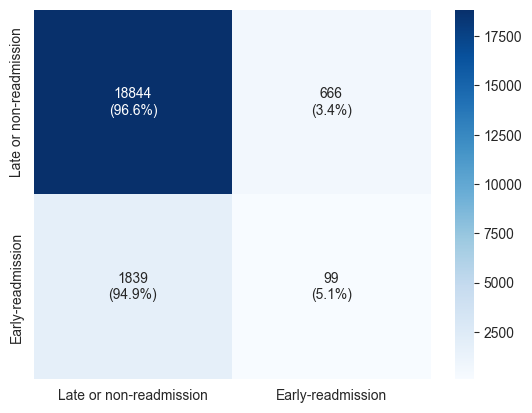

In [24]:
# Visualize confusion matrix with both absolute and percentage values
cm_none = confusion_matrix(y_test, y_test_pred_none)
cm_none_norm = confusion_matrix(y_test, y_test_pred_none, normalize='true')

annotations_none = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_none, cm_none_norm)
])

sns.heatmap(
    cm_none,
    annot=annotations_none,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **3. Optuna Hyper-parameter Tuning | Undersampling**
Hyper-parameter tuning of the model using Optuna, and undersampling with RandomUnderSampler.

### 3.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [25]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"]),
        "splitter": trial.suggest_categorical("splitter", ["best", "random"]),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", [None, "sqrt", "log2"]),
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        RandomUnderSampler(random_state=RANDOM_STATE),
        DecisionTreeClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [26]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_RUS))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-14 19:25:48,779] A new study created in Journal with name: Diabetes_130-US


### 3.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [27]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2025-01-14 19:25:49,898] Trial 1 finished with value: 0.44950236655875386 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 16, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 1 with value: 0.44950236655875386.
[I 2025-01-14 19:25:50,019] Trial 4 finished with value: 0.45791691402178814 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 5 with value: 0.4842739036406073.


Cross validation scores: [0.444052   0.44416592 0.45230366 0.44719652 0.45979374]
Average score: 0.44950236655875386
Cross validation scores: [0.45124425 0.45976354 0.45674206 0.47322821 0.44860652]
Average score: 0.45791691402178814
Cross validation scores: [0.475789   0.48545079 0.49957082 0.47656399 0.48399492]
Average score: 0.4842739036406073
Cross validation scores: [0.46756199 0.47656152 0.48005716 0.50741807 0.47906615]
Average score: 0.4821329780810009


[I 2025-01-14 19:25:50,048] Trial 5 finished with value: 0.4842739036406073 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 20, 'min_samples_split': 17, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.4842739036406073.
[I 2025-01-14 19:25:50,193] Trial 7 finished with value: 0.46176135294402787 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 16, 'min_samples_split': 20, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 5 with value: 0.4842739036406073.
[I 2025-01-14 19:25:50,211] Trial 2 finished with value: 0.4821329780810009 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 7, 'min_samples_split': 17, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 0 with value: 0.49173319991954384.
[I 2025-01-14 19:25:50,228] Trial 6 finished with value: 0.4570782912348757 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 19, 'min_samples_split': 15, 'm

Cross validation scores: [0.44959153 0.46069098 0.45617403 0.46345458 0.45548033]
Average score: 0.4570782912348757
Cross validation scores: [0.48722888 0.47387127 0.47506793 0.50206423 0.52043368]
Average score: 0.49173319991954384
Cross validation scores: [0.48067204 0.45971296 0.47483763 0.4688859  0.47164759]
Average score: 0.47115122514553154
Cross validation scores: [0.46074388 0.45357941 0.45813685 0.46538831 0.47095831]
Average score: 0.46176135294402787


[I 2025-01-14 19:25:50,263] Trial 0 finished with value: 0.49173319991954384 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 15, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.49173319991954384.
[I 2025-01-14 19:25:50,310] Trial 3 finished with value: 0.47115122514553154 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.49173319991954384.
[I 2025-01-14 19:25:50,405] Trial 8 finished with value: 0.459790947778672 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.49173319991954384.


Cross validation scores: [0.43915965 0.46266742 0.47572147 0.46318172 0.45822449]
Average score: 0.459790947778672
Cross validation scores: [0.4828923  0.50958999 0.50063938 0.50725698 0.48585724]
Average score: 0.49724717595133744
Cross validation scores: [0.5083124  0.5006798  0.52198635 0.51173163 0.51808316]
Average score: 0.5121586699275689


[I 2025-01-14 19:25:50,945] Trial 10 finished with value: 0.5121586699275689 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 10, 'min_samples_split': 18, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.5121586699275689.
[I 2025-01-14 19:25:50,948] Trial 9 finished with value: 0.49724717595133744 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 10 with value: 0.5121586699275689.
[I 2025-01-14 19:25:51,306] Trial 11 finished with value: 0.4647708030172593 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 10 with value: 0.5121586699275689.
[I 2025-01-14 19:25:51,355] Trial 12 finished with value: 0.4485318691088481 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 18, 'min_samples_s

Cross validation scores: [0.46537714 0.47584513 0.47114429 0.45813912 0.45334834]
Average score: 0.4647708030172593
Cross validation scores: [0.44982253 0.44940805 0.45260406 0.44841769 0.44240703]
Average score: 0.4485318691088481
Cross validation scores: [0.46152304 0.4603083  0.47737169 0.47436937 0.46299228]
Average score: 0.4673129362185233


[I 2025-01-14 19:25:51,478] Trial 14 finished with value: 0.4673129362185233 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 14, 'min_samples_split': 18, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.5121586699275689.
[I 2025-01-14 19:25:51,578] Trial 13 finished with value: 0.4557513621651177 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 14, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.5244213796095524.
[I 2025-01-14 19:25:51,600] Trial 15 finished with value: 0.49918061424223803 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.5244213796095524.


Cross validation scores: [0.45895296 0.49151589 0.51270426 0.51910233 0.51362762]
Average score: 0.49918061424223803
Cross validation scores: [0.45600407 0.46529223 0.45096707 0.45378471 0.45270873]
Average score: 0.4557513621651177
Cross validation scores: [0.52023964 0.53030024 0.52574643 0.52720317 0.51861742]
Average score: 0.5244213796095524
Cross validation scores: [0.52098483 0.44804812 0.49498534 0.49928128 0.51176375]
Average score: 0.49501266405008765


[I 2025-01-14 19:25:51,624] Trial 16 finished with value: 0.5244213796095524 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 16 with value: 0.5244213796095524.
[I 2025-01-14 19:25:51,688] Trial 17 finished with value: 0.49501266405008765 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.5244213796095524.
[I 2025-01-14 19:25:51,809] Trial 18 finished with value: 0.5395988142370619 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 13, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:25:52,474] Trial 19 finished with value: 0.5190684338088966 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 2, 'min_samples_split': 14, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.51611374 0.52462146 0.52574643 0.51595657 0.51290396]
Average score: 0.5190684338088966
Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:25:52,580] Trial 20 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 13, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:52,657] Trial 21 finished with value: 0.5174806911308296 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.51611374 0.52667108 0.52201347 0.51214591 0.51045925]
Average score: 0.5174806911308296
Cross validation scores: [0.51611374 0.52667108 0.52201347 0.51214591 0.51045925]
Average score: 0.5174806911308296


[I 2025-01-14 19:25:52,773] Trial 22 finished with value: 0.5174806911308296 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:52,994] Trial 25 finished with value: 0.5311437773381321 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 9, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.52868053 0.54030017 0.54378673 0.52799793 0.51495353]
Average score: 0.5311437773381321
Cross validation scores: [0.52868053 0.54030017 0.54378673 0.52799793 0.51495353]
Average score: 0.5311437773381321
Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905
Cross validation scores: [0.48891221 0.51208401 0.49913741 0.50680923 0.48473616]
Average score: 0.4983358039111915


[I 2025-01-14 19:25:53,092] Trial 24 finished with value: 0.5311437773381321 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 9, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:53,109] Trial 26 finished with value: 0.4983358039111915 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:53,126] Trial 23 finished with value: 0.538581560994905 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 9, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:53,425] Trial 27 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 13

Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619
Cross validation scores: [0.51027403 0.49289476 0.54784118 0.49426454 0.52801335]
Average score: 0.5146575728990938


[I 2025-01-14 19:25:53,561] Trial 28 finished with value: 0.5146575728990938 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619
Cross validation scores: [0.53399636 0.48857252 0.5303779  0.4929706  0.49901726]
Average score: 0.5089869274011687


[I 2025-01-14 19:25:53,970] Trial 29 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:54,018] Trial 30 finished with value: 0.5089869274011687 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:54,086] Trial 31 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 13, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:25:54,387] Trial 33 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:54,414] Trial 32 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619
Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619
Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619
Cross validation scores: [0.51259189 0.49336527 0.51609598 0.49110155 0.48844027]
Average score: 0.5003189913117967


[I 2025-01-14 19:25:54,540] Trial 34 finished with value: 0.5395988142370619 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:54,584] Trial 35 finished with value: 0.5003189913117967 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.54022813 0.5435282  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5394653580207773


[I 2025-01-14 19:25:54,698] Trial 36 finished with value: 0.5394653580207773 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:55,024] Trial 37 finished with value: 0.5151449383846844 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.50767118 0.51500317 0.52485121 0.51528808 0.51291105]
Average score: 0.5151449383846844
Cross validation scores: [0.49405486 0.47305668 0.5009346  0.49748501 0.49301438]
Average score: 0.4917091072466909


[I 2025-01-14 19:25:55,120] Trial 39 finished with value: 0.48995256169446516 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 12, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:55,122] Trial 38 finished with value: 0.4917091072466909 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 11, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.50391044 0.48766128 0.4663526  0.50169012 0.49014837]
Average score: 0.48995256169446516


[I 2025-01-14 19:25:55,620] Trial 40 finished with value: 0.5085136842900919 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.47774091 0.4923586  0.52793665 0.52407194 0.52046032]
Average score: 0.5085136842900919
Cross validation scores: [0.53120062 0.52140675 0.53016256 0.49257894 0.49901726]
Average score: 0.514873225986088


[I 2025-01-14 19:25:55,725] Trial 41 finished with value: 0.514873225986088 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:55,842] Trial 43 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619
Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619
Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:25:55,886] Trial 42 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:55,936] Trial 44 finished with value: 0.5395988142370619 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:56,139] Trial 45 finished with value: 0.4538049072004856 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 1, 'min_samples_split': 19, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.41547765 0.47023357 0.42280585 0.4669373  0.49357017]
Average score: 0.4538049072004856
Cross validation scores: [0.51611374 0.52667108 0.52201347 0.51214591 0.51045925]
Average score: 0.5174806911308296
Cross validation scores: [0.51611374 0.52667108 0.52201347 0.51214591 0.51045925]
Average score: 0.5174806911308296


[I 2025-01-14 19:25:56,209] Trial 47 finished with value: 0.5174806911308296 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:56,390] Trial 46 finished with value: 0.5174806911308296 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:56,539] Trial 48 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 15, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619
Cross validation scores: [0.52868053 0.54030017 0.54378673 0.52799793 0.51495353]
Average score: 0.5311437773381321


[I 2025-01-14 19:25:56,651] Trial 49 finished with value: 0.5311437773381321 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:25:56,999] Trial 50 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:57,244] Trial 52 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 14, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619
Cross validation scores: [0.45895296 0.49151589 0.51118947 0.51910233 0.47590434]
Average score: 0.4913329975353052
Cross validation scores: [0.46895234 0.475953   0.4986161  0.51034783 0.49287833]
Average score: 0.4893495196907942


[I 2025-01-14 19:25:57,317] Trial 51 finished with value: 0.4913329975353052 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:57,327] Trial 53 finished with value: 0.4893495196907942 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:57,494] Trial 54 finished with value: 0.46176135294402787 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:57,538] Trial 55 finished with value: 0.5311437773381321 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 1, 'min_samples_split'

Cross validation scores: [0.46074388 0.45357941 0.45813685 0.46538831 0.47095831]
Average score: 0.46176135294402787
Cross validation scores: [0.52868053 0.54030017 0.54378673 0.52799793 0.51495353]
Average score: 0.5311437773381321
Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:25:57,649] Trial 56 finished with value: 0.5395988142370619 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:57,784] Trial 57 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619
Cross validation scores: [0.52023964 0.53030024 0.52574643 0.52720317 0.51861742]
Average score: 0.5244213796095524


[I 2025-01-14 19:25:58,104] Trial 58 finished with value: 0.5244213796095524 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:25:58,442] Trial 61 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 14, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.52868053 0.54030017 0.54378673 0.52799793 0.51495353]
Average score: 0.5311437773381321
Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:25:58,687] Trial 59 finished with value: 0.5311437773381321 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 16, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:58,716] Trial 60 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:58,938] Trial 62 finished with value: 0.5244213796095524 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:58,942] Trial 63 finished with value: 0.5141954385879336 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 1

Cross validation scores: [0.52023964 0.53030024 0.52574643 0.52720317 0.51861742]
Average score: 0.5244213796095524
Cross validation scores: [0.50767118 0.51552779 0.52469063 0.51395023 0.50913736]
Average score: 0.5141954385879336
Cross validation scores: [0.48003568 0.50409292 0.4543173  0.49185694 0.451357  ]
Average score: 0.4763319676611208
Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:25:59,081] Trial 64 finished with value: 0.4763319676611208 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:59,222] Trial 65 finished with value: 0.5395988142370619 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619
Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:25:59,428] Trial 66 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:59,509] Trial 67 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.52868053 0.54030017 0.54378673 0.52799793 0.51495353]
Average score: 0.5311437773381321
Cross validation scores: [0.50363319 0.47438598 0.49349845 0.49404382 0.49934584]
Average score: 0.49298145778591085


[I 2025-01-14 19:25:59,909] Trial 68 finished with value: 0.5311437773381321 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 14, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:25:59,946] Trial 69 finished with value: 0.49298145778591085 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:26:00,136] Trial 71 finished with value: 0.4669892772722492 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:26:00,153] Trial 70 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split

Cross validation scores: [0.46718685 0.47315481 0.47433162 0.46305238 0.45722072]
Average score: 0.4669892772722492
Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619
Cross validation scores: [0.50736244 0.51496043 0.52469063 0.51528808 0.51233491]
Average score: 0.5149272991426386


[I 2025-01-14 19:26:00,266] Trial 72 finished with value: 0.5149272991426386 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.528146   0.52462146 0.52574643 0.51595657 0.51290396]
Average score: 0.5214748865776689


[I 2025-01-14 19:26:00,467] Trial 73 finished with value: 0.5214748865776689 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.51611374 0.52667108 0.52201347 0.51214591 0.51045925]
Average score: 0.5174806911308296
Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:26:00,703] Trial 74 finished with value: 0.5174806911308296 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:26:00,812] Trial 75 finished with value: 0.5395988142370619 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 12, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:26:01,085] Trial 77 finished with value: 0.5174806911308296 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.51611374 0.52667108 0.52201347 0.51214591 0.51045925]
Average score: 0.5174806911308296
Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619
Cross validation scores: [0.52868053 0.54030017 0.54378673 0.52799793 0.51495353]
Average score: 0.5311437773381321


[I 2025-01-14 19:26:01,208] Trial 78 finished with value: 0.5311437773381321 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 15, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:26:01,217] Trial 76 finished with value: 0.5395988142370619 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:26:01,392] Trial 79 finished with value: 0.5395988142370619 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619
Cross validation scores: [0.50628556 0.50076989 0.49550247 0.47494707 0.48902043]
Average score: 0.4933050851469081


[I 2025-01-14 19:26:01,508] Trial 80 finished with value: 0.4933050851469081 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 13, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:26:01,576] Trial 81 finished with value: 0.48661436497684996 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.44650414 0.46686882 0.51270426 0.51910233 0.48789228]
Average score: 0.48661436497684996
Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905
Cross validation scores: [0.528146   0.52462146 0.52574643 0.51595657 0.51290396]
Average score: 0.5214748865776689


[I 2025-01-14 19:26:01,948] Trial 82 finished with value: 0.538581560994905 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:26:02,057] Trial 83 finished with value: 0.5214748865776689 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:26:02,285] Trial 84 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:26:02,474] Trial 86 finished with value: 0.5395988142370619 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619
Cross validation scores: [0.528146   0.53030024 0.52574643 0.52720317 0.51485514]
Average score: 0.5252501960988363


[I 2025-01-14 19:26:02,746] Trial 87 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:26:02,766] Trial 85 finished with value: 0.5252501960988363 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619
Cross validation scores: [0.528146   0.52462146 0.52574643 0.51595657 0.51290396]
Average score: 0.5214748865776689
Cross validation scores: [0.52868053 0.54030017 0.54378673 0.52799793 0.51495353]
Average score: 0.5311437773381321


[I 2025-01-14 19:26:02,883] Trial 88 finished with value: 0.5214748865776689 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:26:02,950] Trial 90 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:26:03,024] Trial 89 finished with value: 0.5311437773381321 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 11, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619
Cross validation scores: [0.51528739 0.52667108 0.5220942  0.51214591 0.51045925]
Average score: 0.5173315666292378


[I 2025-01-14 19:26:03,163] Trial 91 finished with value: 0.5173315666292378 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:26:03,268] Trial 92 finished with value: 0.538581560994905 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 1, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


[I 2025-01-14 19:26:03,596] Trial 93 finished with value: 0.5395988142370619 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619
Cross validation scores: [0.47677433 0.48639538 0.48893703 0.48302316 0.47441945]
Average score: 0.4819098695319151


[I 2025-01-14 19:26:03,823] Trial 95 finished with value: 0.4819098695319151 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:26:03,902] Trial 94 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 18 with value: 0.5395988142370619.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619
Cross validation scores: [0.528146   0.52462146 0.52574643 0.51595657 0.51290396]
Average score: 0.5214748865776689


[I 2025-01-14 19:26:04,034] Trial 96 finished with value: 0.5214748865776689 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:26:04,090] Trial 98 finished with value: 0.5311437773381321 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 3, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:26:04,148] Trial 97 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 12, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 18 with value: 0.5395988142370619.
[I 2025-01-14 19:26:04,168] Trial 99 finished with value: 0.4847432872974305 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 19, 'min_samples_split': 12, 

Cross validation scores: [0.52868053 0.54030017 0.54378673 0.52799793 0.51495353]
Average score: 0.5311437773381321
Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619
Cross validation scores: [0.48436029 0.48621669 0.49368506 0.4752007  0.4842537 ]
Average score: 0.4847432872974305


In [28]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 18
Best Parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 13, 'min_samples_leaf': 17, 'max_features': 'sqrt'}
Best Value: 0.5395988142370619


### 3.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [29]:
optuna.visualization.plot_optimization_history(study)

In [30]:
optuna.visualization.plot_slice(study)

In [31]:
optuna.visualization.plot_param_importances(study)

In [32]:
optuna.visualization.plot_parallel_coordinate(study)

In [33]:
optuna.visualization.plot_contour(study)

In [34]:
optuna.visualization.plot_timeline(study)

### 3.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [35]:
# Fit best model on the training set
best_params = study.best_params

pipeline_rus = make_pipeline(
    RandomUnderSampler(random_state=RANDOM_STATE),
    DecisionTreeClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_rus.fit(X_train, y_train)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=38)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=2,
                                        max_features='sqrt',
                                        min_samples_leaf=17,
                                        min_samples_split=13, random_state=38,
                                        splitter='random'))])

In [36]:
# Predictions
y_train_pred_rus = pipeline_rus.predict(X_train)
y_test_pred_rus = pipeline_rus.predict(X_test)

In [37]:
ac_train_rus = accuracy_score(y_train, y_train_pred_rus)
ac_test_rus = accuracy_score(y_test, y_test_pred_rus)

print('Train accuracy: ', ac_train_rus)
print('Test accuracy: ', ac_test_rus)

Train accuracy:  0.7561794385053452
Test accuracy:  0.7527974636329727


In [38]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_rus,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.93      0.79      0.85     19510
      Early-readmission       0.15      0.39      0.22      1938

               accuracy                           0.75     21448
              macro avg       0.54      0.59      0.54     21448
           weighted avg       0.86      0.75      0.80     21448



In [39]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_rus = recall_score(y_test, y_test_pred_rus, average='macro')
precision_rus = precision_score(y_test, y_test_pred_rus, average='macro')
f1_rus = f1_score(y_test, y_test_pred_rus, average='macro')
roc_auc_rus = roc_auc_score(y_test, y_test_pred_rus, average='macro')
accuracy_rus = accuracy_score(y_test, y_test_pred_rus)

<Axes: >

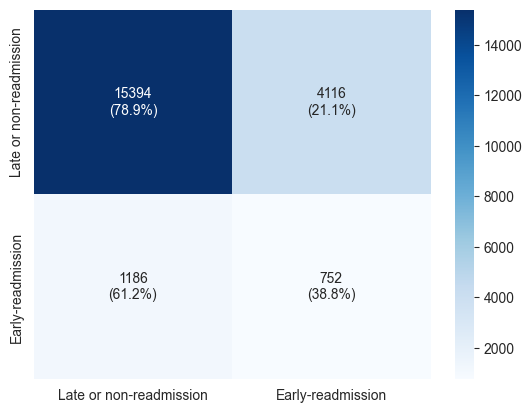

In [40]:
# Visualize confusion matrix with both absolute and percentage values
cm_rus = confusion_matrix(y_test, y_test_pred_rus)
cm_rus_norm = confusion_matrix(y_test, y_test_pred_rus, normalize='true')

annotations_rus = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_rus, cm_rus_norm)
])

sns.heatmap(
    cm_rus,
    annot=annotations_rus,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **4. Optuna Hyper-parameter Tuning | SMOTE**
Hyper-parameter tuning of the model using Optuna, and oversampling with SMOTE.

### 4.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [41]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"]),
        "splitter": trial.suggest_categorical("splitter", ["best", "random"]),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", [None, "sqrt", "log2"]),
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTE(random_state=RANDOM_STATE),
        DecisionTreeClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [42]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-14 19:26:05,837] A new study created in Journal with name: Diabetes_130-US


### 4.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [43]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2025-01-14 19:26:07,951] Trial 2 finished with value: 0.5395988142370619 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 2 with value: 0.5395988142370619.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:26:08,716] Trial 7 finished with value: 0.21907652201463526 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5395988142370619.


Cross validation scores: [0.21906585 0.21784363 0.22125303 0.21919042 0.21802969]
Average score: 0.21907652201463526


[I 2025-01-14 19:26:09,036] Trial 0 finished with value: 0.41931895201052594 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 2 with value: 0.5395988142370619.


Cross validation scores: [0.41503779 0.4187567  0.42274296 0.4162271  0.42383022]
Average score: 0.41931895201052594


[I 2025-01-14 19:26:09,307] Trial 1 finished with value: 0.5085026541659013 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 2 with value: 0.5395988142370619.
[I 2025-01-14 19:26:09,431] Trial 5 finished with value: 0.41935664586390226 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 2 with value: 0.5395988142370619.


Cross validation scores: [0.50639183 0.51010031 0.49715484 0.50239996 0.52646633]
Average score: 0.5085026541659013
Cross validation scores: [0.41528915 0.4187567  0.42268007 0.4162271  0.42383022]
Average score: 0.41935664586390226
Cross validation scores: [0.32909088 0.33505974 0.33418532 0.33513883 0.33404903]
Average score: 0.3335047608521264


[I 2025-01-14 19:26:09,569] Trial 4 finished with value: 0.3335047608521264 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 2 with value: 0.5395988142370619.
[I 2025-01-14 19:26:09,664] Trial 6 finished with value: 0.5178355892967631 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5395988142370619.


Cross validation scores: [0.51906546 0.50831086 0.51821009 0.52421282 0.51937871]
Average score: 0.5178355892967631
Cross validation scores: [0.46908541 0.47005427 0.47557226 0.46585495 0.46865533]
Average score: 0.4698444449754617


[I 2025-01-14 19:26:09,815] Trial 3 finished with value: 0.4698444449754617 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 2 with value: 0.5395988142370619.
[I 2025-01-14 19:26:10,362] Trial 8 finished with value: 0.5046175010418601 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 13, 'min_samples_split': 14, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 2 with value: 0.5395988142370619.


Cross validation scores: [0.50274788 0.51253181 0.50392868 0.50029945 0.50357969]
Average score: 0.5046175010418601


[I 2025-01-14 19:26:11,369] Trial 10 finished with value: 0.21907652201463526 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5395988142370619.


Cross validation scores: [0.21906585 0.21784363 0.22125303 0.21919042 0.21802969]
Average score: 0.21907652201463526


[I 2025-01-14 19:26:12,098] Trial 14 finished with value: 0.5402599098589085 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 14 with value: 0.5402599098589085.
[I 2025-01-14 19:26:12,167] Trial 13 finished with value: 0.4972348135234065 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 14 with value: 0.5402599098589085.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.5352439  0.53553739]
Average score: 0.5402599098589085
Cross validation scores: [0.48963117 0.51003041 0.4906796  0.50551639 0.49031649]
Average score: 0.4972348135234065


[I 2025-01-14 19:26:12,538] Trial 15 finished with value: 0.506129557024656 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 14 with value: 0.5402599098589085.


Cross validation scores: [0.52683582 0.52065762 0.54020888 0.47451992 0.46842553]
Average score: 0.506129557024656


[I 2025-01-14 19:26:13,020] Trial 16 finished with value: 0.4885295490983189 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.5402599098589085.


Cross validation scores: [0.49835413 0.52289212 0.46914929 0.47906326 0.47318895]
Average score: 0.4885295490983189
Cross validation scores: [0.51663724 0.51965273 0.52434538 0.51816113 0.52035651]
Average score: 0.5198306002664974


[I 2025-01-14 19:26:13,225] Trial 9 finished with value: 0.5198306002664974 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 14, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 14 with value: 0.5402599098589085.
[I 2025-01-14 19:26:13,991] Trial 17 finished with value: 0.5163870896276512 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 14 with value: 0.5402599098589085.


Cross validation scores: [0.51200273 0.49979917 0.53344733 0.52242053 0.51426569]
Average score: 0.5163870896276512
Cross validation scores: [0.50714107 0.51457618 0.52382521 0.51747471 0.51283061]
Average score: 0.5151695576912444


[I 2025-01-14 19:26:14,197] Trial 11 finished with value: 0.5151695576912444 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 14 with value: 0.5402599098589085.
[I 2025-01-14 19:26:14,512] Trial 12 finished with value: 0.5117703802623067 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 14 with value: 0.5402599098589085.


Cross validation scores: [0.5074075  0.50565013 0.52112471 0.51235135 0.51231821]
Average score: 0.5117703802623067
Cross validation scores: [0.52868053 0.54030017 0.54378673 0.52799793 0.51495353]
Average score: 0.5311437773381321


[I 2025-01-14 19:26:14,763] Trial 19 finished with value: 0.5311437773381321 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 14 with value: 0.5402599098589085.
[I 2025-01-14 19:26:14,839] Trial 18 finished with value: 0.5163870896276512 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 14 with value: 0.5402599098589085.


Cross validation scores: [0.51200273 0.49979917 0.53344733 0.52242053 0.51426569]
Average score: 0.5163870896276512
Cross validation scores: [0.54013255 0.544589   0.54579671 0.5352439  0.53553739]
Average score: 0.5402599098589085


[I 2025-01-14 19:26:14,986] Trial 20 finished with value: 0.5402599098589085 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 14 with value: 0.5402599098589085.
[I 2025-01-14 19:26:15,470] Trial 21 finished with value: 0.5402535005632548 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 14 with value: 0.5402599098589085.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.53521185 0.53553739]
Average score: 0.5402535005632548


[I 2025-01-14 19:26:15,771] Trial 22 finished with value: 0.5063309968162621 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 14 with value: 0.5402599098589085.


Cross validation scores: [0.48724662 0.5100783  0.51594987 0.52246938 0.49591082]
Average score: 0.5063309968162621


[I 2025-01-14 19:26:16,272] Trial 23 finished with value: 0.5395988142370619 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 14 with value: 0.5402599098589085.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:26:16,643] Trial 24 finished with value: 0.5311437773381321 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 14 with value: 0.5402599098589085.


Cross validation scores: [0.52868053 0.54030017 0.54378673 0.52799793 0.51495353]
Average score: 0.5311437773381321


[I 2025-01-14 19:26:17,180] Trial 25 finished with value: 0.4982352536900786 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 11, 'min_samples_split': 16, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 14 with value: 0.5402599098589085.


Cross validation scores: [0.49175604 0.51672162 0.50023916 0.47612135 0.50633809]
Average score: 0.4982352536900786


[I 2025-01-14 19:26:17,532] Trial 27 finished with value: 0.5403284190811217 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.
[I 2025-01-14 19:26:17,601] Trial 26 finished with value: 0.49683059154866005 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.5352439  0.53587994]
Average score: 0.5403284190811217
Cross validation scores: [0.50348441 0.50078446 0.51014804 0.49408225 0.4756538 ]
Average score: 0.49683059154866005
Cross validation scores: [0.52752899 0.54208713 0.52545635 0.51792327 0.51403523]
Average score: 0.5254061943886553


[I 2025-01-14 19:26:17,768] Trial 28 finished with value: 0.5254061943886553 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.
[I 2025-01-14 19:26:17,950] Trial 29 finished with value: 0.53125922188554 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.53279722 0.5299748  0.53042079 0.52667037 0.53643293]
Average score: 0.53125922188554
Cross validation scores: [0.53279722 0.5299748  0.53042079 0.52660383 0.53662552]
Average score: 0.5312844329541513


[I 2025-01-14 19:26:18,148] Trial 30 finished with value: 0.5312844329541513 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.
[I 2025-01-14 19:26:18,625] Trial 31 finished with value: 0.5190959275054288 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.51820531 0.51138933 0.52179646 0.52231932 0.52176922]
Average score: 0.5190959275054288
Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:26:18,850] Trial 32 finished with value: 0.5395988142370619 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 27 with value: 0.5403284190811217.
[I 2025-01-14 19:26:19,584] Trial 33 finished with value: 0.53125922188554 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.53279722 0.5299748  0.53042079 0.52667037 0.53643293]
Average score: 0.53125922188554


[I 2025-01-14 19:26:20,056] Trial 34 finished with value: 0.5164086874678029 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.51884318 0.510144   0.52260085 0.52036102 0.51009439]
Average score: 0.5164086874678029


[I 2025-01-14 19:26:20,388] Trial 35 finished with value: 0.5403284190811217 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.5352439  0.53587994]
Average score: 0.5403284190811217
Cross validation scores: [0.48744084 0.49155917 0.52561669 0.50922037 0.50012637]
Average score: 0.5027926853406652


[I 2025-01-14 19:26:20,636] Trial 36 finished with value: 0.5027926853406652 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.
[I 2025-01-14 19:26:20,790] Trial 37 finished with value: 0.5402599098589085 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.5352439  0.53553739]
Average score: 0.5402599098589085
Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:26:20,987] Trial 38 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.
[I 2025-01-14 19:26:21,342] Trial 39 finished with value: 0.5248516586200813 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.52218109 0.52375228 0.53241941 0.52871588 0.51718963]
Average score: 0.5248516586200813
Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:26:21,461] Trial 40 finished with value: 0.5395988142370619 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 27 with value: 0.5403284190811217.
[I 2025-01-14 19:26:22,258] Trial 41 finished with value: 0.5402599098589085 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.5352439  0.53553739]
Average score: 0.5402599098589085


[I 2025-01-14 19:26:22,739] Trial 42 finished with value: 0.21907652201463526 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 1, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.21906585 0.21784363 0.22125303 0.21919042 0.21802969]
Average score: 0.21907652201463526


[I 2025-01-14 19:26:23,158] Trial 43 finished with value: 0.5078473198308069 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.5241613  0.53323865 0.54005026 0.47362697 0.46815941]
Average score: 0.5078473198308069


[I 2025-01-14 19:26:23,738] Trial 45 finished with value: 0.5311808731956598 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.53213853 0.53004206 0.53042079 0.52687007 0.53643293]
Average score: 0.5311808731956598


[I 2025-01-14 19:26:24,137] Trial 44 finished with value: 0.5121270271687914 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.53167688 0.47713052 0.50372403 0.52635558 0.52174812]
Average score: 0.5121270271687914
Cross validation scores: [0.37360033 0.38034741 0.37879957 0.36930746 0.37026329]
Average score: 0.374463611672567


[I 2025-01-14 19:26:24,310] Trial 46 finished with value: 0.374463611672567 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.
[I 2025-01-14 19:26:24,473] Trial 47 finished with value: 0.5403284190811217 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.5352439  0.53587994]
Average score: 0.5403284190811217


[I 2025-01-14 19:26:24,775] Trial 48 finished with value: 0.5395988142370619 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:26:25,840] Trial 50 finished with value: 0.5403284190811217 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.
[I 2025-01-14 19:26:25,841] Trial 49 finished with value: 0.5040759432795108 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.5352439  0.53587994]
Average score: 0.5403284190811217
Cross validation scores: [0.51661608 0.51833308 0.4957226  0.49950145 0.49020651]
Average score: 0.5040759432795108


[I 2025-01-14 19:26:26,304] Trial 51 finished with value: 0.5313320585520369 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.5328563  0.52939622 0.53186418 0.52611067 0.53643293]
Average score: 0.5313320585520369


[I 2025-01-14 19:26:26,693] Trial 52 finished with value: 0.5395988142370619 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:26:27,010] Trial 53 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:26:27,434] Trial 55 finished with value: 0.5403284190811217 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.5352439  0.53587994]
Average score: 0.5403284190811217
Cross validation scores: [0.52868053 0.54030017 0.54378673 0.52799793 0.51495353]
Average score: 0.5311437773381321


[I 2025-01-14 19:26:27,670] Trial 56 finished with value: 0.5311437773381321 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.
[I 2025-01-14 19:26:28,063] Trial 54 finished with value: 0.49319909999536166 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.5325097  0.44804398 0.48629627 0.52200202 0.47714354]
Average score: 0.49319909999536166


[I 2025-01-14 19:26:28,615] Trial 57 finished with value: 0.5311136124342106 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.53193537 0.53004206 0.53042079 0.52673692 0.53643293]
Average score: 0.5311136124342106
Cross validation scores: [0.54013255 0.544589   0.54579671 0.5352439  0.53587994]
Average score: 0.5403284190811217


[I 2025-01-14 19:26:28,843] Trial 58 finished with value: 0.5403284190811217 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.
[I 2025-01-14 19:26:29,043] Trial 59 finished with value: 0.5247447834730115 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.52306193 0.52335669 0.53213137 0.52829786 0.51687607]
Average score: 0.5247447834730115


[I 2025-01-14 19:26:29,359] Trial 60 finished with value: 0.5395988142370619 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:26:29,574] Trial 61 finished with value: 0.5395988142370619 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:26:30,224] Trial 63 finished with value: 0.5402599098589085 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.5352439  0.53553739]
Average score: 0.5402599098589085
Cross validation scores: [0.50716438 0.48897085 0.47015538 0.49392313 0.49490246]
Average score: 0.4910232410739674


[I 2025-01-14 19:26:30,465] Trial 62 finished with value: 0.4910232410739674 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.
[I 2025-01-14 19:26:30,592] Trial 64 finished with value: 0.5254356288790548 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.52306193 0.52375228 0.53492319 0.52823103 0.51720971]
Average score: 0.5254356288790548


[I 2025-01-14 19:26:31,372] Trial 66 finished with value: 0.5402599098589085 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.5352439  0.53553739]
Average score: 0.5402599098589085


[I 2025-01-14 19:26:31,777] Trial 67 finished with value: 0.5158661926175212 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.51795694 0.51145385 0.52123813 0.51833096 0.51035107]
Average score: 0.5158661926175212


[I 2025-01-14 19:26:32,005] Trial 68 finished with value: 0.5312356091269039 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.53220627 0.53004206 0.53042079 0.5268834  0.53662552]
Average score: 0.5312356091269039
Cross validation scores: [0.54055731 0.54362686 0.54553079 0.53491596 0.5331237 ]
Average score: 0.539550925912241


[I 2025-01-14 19:26:32,214] Trial 69 finished with value: 0.539550925912241 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.
[I 2025-01-14 19:26:32,957] Trial 70 finished with value: 0.5403284190811217 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.5352439  0.53587994]
Average score: 0.5403284190811217
Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:26:33,197] Trial 71 finished with value: 0.5395988142370619 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.
[I 2025-01-14 19:26:33,524] Trial 72 finished with value: 0.5313320585520369 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.5328563  0.52939622 0.53186418 0.52611067 0.53643293]
Average score: 0.5313320585520369


[I 2025-01-14 19:26:33,976] Trial 65 finished with value: 0.5116827661331053 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 12, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 27 with value: 0.5403284190811217.
[I 2025-01-14 19:26:34,071] Trial 73 finished with value: 0.5401220872102889 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.50779938 0.50634162 0.52022512 0.51266306 0.51138466]
Average score: 0.5116827661331053
Cross validation scores: [0.54013255 0.544589   0.54511368 0.53523781 0.53553739]
Average score: 0.5401220872102889


[I 2025-01-14 19:26:34,307] Trial 74 finished with value: 0.5247972506427823 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.52306193 0.52335669 0.53224913 0.52858204 0.51673646]
Average score: 0.5247972506427823


[I 2025-01-14 19:26:34,626] Trial 75 finished with value: 0.539550925912241 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54055731 0.54362686 0.54553079 0.53491596 0.5331237 ]
Average score: 0.539550925912241


[I 2025-01-14 19:26:34,828] Trial 76 finished with value: 0.5403284190811217 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.5352439  0.53587994]
Average score: 0.5403284190811217


[I 2025-01-14 19:26:35,319] Trial 77 finished with value: 0.5311437773381321 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.52868053 0.54030017 0.54378673 0.52799793 0.51495353]
Average score: 0.5311437773381321


[I 2025-01-14 19:26:35,657] Trial 78 finished with value: 0.5403284190811217 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.5352439  0.53587994]
Average score: 0.5403284190811217


[I 2025-01-14 19:26:36,044] Trial 79 finished with value: 0.531112062059654 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.53193537 0.5299748  0.53042079 0.52660383 0.53662552]
Average score: 0.531112062059654


[I 2025-01-14 19:26:36,632] Trial 80 finished with value: 0.5395988142370619 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.
[I 2025-01-14 19:26:36,730] Trial 81 finished with value: 0.5311808731956598 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619
Cross validation scores: [0.53213853 0.53004206 0.53042079 0.52687007 0.53643293]
Average score: 0.5311808731956598


[I 2025-01-14 19:26:37,002] Trial 82 finished with value: 0.5403284190811217 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.5352439  0.53587994]
Average score: 0.5403284190811217


[I 2025-01-14 19:26:37,349] Trial 83 finished with value: 0.5395988142370619 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:26:38,487] Trial 84 finished with value: 0.4563143749602082 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.44866289 0.46196171 0.38262323 0.45961286 0.52871118]
Average score: 0.4563143749602082
Cross validation scores: [0.51933983 0.52632934 0.5298209  0.51788482 0.52157777]
Average score: 0.5229905345148116


[I 2025-01-14 19:26:38,752] Trial 85 finished with value: 0.5229905345148116 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 27 with value: 0.5403284190811217.
[I 2025-01-14 19:26:38,760] Trial 86 finished with value: 0.5158758062629227 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.5171031  0.51145385 0.52122326 0.51892756 0.51067125]
Average score: 0.5158758062629227


[I 2025-01-14 19:26:39,169] Trial 87 finished with value: 0.5395988142370619 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:26:39,470] Trial 88 finished with value: 0.5403284190811217 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.
[I 2025-01-14 19:26:39,487] Trial 89 finished with value: 0.5402599098589085 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.5352439  0.53587994]
Average score: 0.5403284190811217
Cross validation scores: [0.54013255 0.544589   0.54579671 0.5352439  0.53553739]
Average score: 0.5402599098589085


[I 2025-01-14 19:26:39,885] Trial 90 finished with value: 0.5313529382156469 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.53279722 0.5299748  0.53063165 0.52675024 0.53661077]
Average score: 0.5313529382156469


[I 2025-01-14 19:26:40,049] Trial 91 finished with value: 0.5395988142370619 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:26:41,472] Trial 92 finished with value: 0.539550925912241 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.
[I 2025-01-14 19:26:41,521] Trial 94 finished with value: 0.5403284190811217 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54055731 0.54362686 0.54553079 0.53491596 0.5331237 ]
Average score: 0.539550925912241
Cross validation scores: [0.54013255 0.544589   0.54579671 0.5352439  0.53587994]
Average score: 0.5403284190811217


[I 2025-01-14 19:26:42,021] Trial 93 finished with value: 0.5403284190811217 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.
[I 2025-01-14 19:26:42,119] Trial 95 finished with value: 0.5248941213433682 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.5352439  0.53587994]
Average score: 0.5403284190811217
Cross validation scores: [0.52306193 0.52375228 0.53213137 0.52864896 0.51687607]
Average score: 0.5248941213433682


[I 2025-01-14 19:26:42,416] Trial 98 finished with value: 0.5403284190811217 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.5352439  0.53587994]
Average score: 0.5403284190811217


[I 2025-01-14 19:26:42,812] Trial 99 finished with value: 0.531112062059654 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.53193537 0.5299748  0.53042079 0.52660383 0.53662552]
Average score: 0.531112062059654


[I 2025-01-14 19:26:43,134] Trial 96 finished with value: 0.5149990634012596 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.
[I 2025-01-14 19:26:43,154] Trial 97 finished with value: 0.5183435734621706 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 27 with value: 0.5403284190811217.


Cross validation scores: [0.5167183  0.51823532 0.51990045 0.50919968 0.51094156]
Average score: 0.5149990634012596
Cross validation scores: [0.53502685 0.52524856 0.52569319 0.50607107 0.4996782 ]
Average score: 0.5183435734621706


In [44]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 27
Best Parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}
Best Value: 0.5403284190811217


### 4.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [45]:
optuna.visualization.plot_optimization_history(study)

In [46]:
optuna.visualization.plot_slice(study)

In [47]:
optuna.visualization.plot_param_importances(study)

In [48]:
optuna.visualization.plot_parallel_coordinate(study)

In [49]:
optuna.visualization.plot_contour(study)

In [50]:
optuna.visualization.plot_timeline(study)

### 4.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [51]:
# Fit best model on the training set
best_params = study.best_params

pipeline_smote = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    DecisionTreeClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_smote.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=38)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='log_loss', max_depth=4,
                                        max_features='log2', min_samples_leaf=2,
                                        random_state=38, splitter='random'))])

In [52]:
# Predictions
y_train_pred_smote = pipeline_smote.predict(X_train)
y_test_pred_smote = pipeline_smote.predict(X_test)

In [53]:
ac_train_smote = accuracy_score(y_train, y_train_pred_smote)
ac_test_smote = accuracy_score(y_test, y_test_pred_smote)

print('Train accuracy: ', ac_train_smote)
print('Test accuracy: ', ac_test_smote)

Train accuracy:  0.759816165451094
Test accuracy:  0.7560145468108914


In [54]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smote,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.93      0.79      0.86     19510
      Early-readmission       0.15      0.38      0.22      1938

               accuracy                           0.76     21448
              macro avg       0.54      0.59      0.54     21448
           weighted avg       0.86      0.76      0.80     21448



In [55]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smote = recall_score(y_test, y_test_pred_smote, average='macro')
precision_smote = precision_score(y_test, y_test_pred_smote, average='macro')
f1_smote = f1_score(y_test, y_test_pred_smote, average='macro')
roc_auc_smote = roc_auc_score(y_test, y_test_pred_smote, average='macro')
accuracy_smote = accuracy_score(y_test, y_test_pred_smote)

<Axes: >

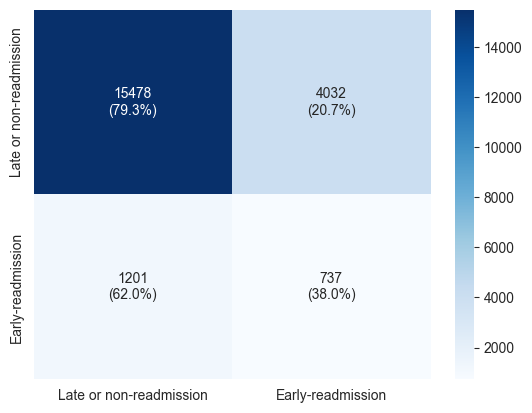

In [56]:
# Visualize confusion matrix with both absolute and percentage values
cm_smote = confusion_matrix(y_test, y_test_pred_smote)
cm_smote_norm = confusion_matrix(y_test, y_test_pred_smote, normalize='true')

annotations_smote = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smote, cm_smote_norm)
])

sns.heatmap(
    cm_smote,
    annot=annotations_smote,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **5. Optuna Hyper-parameter Tuning | SMOTE + Tomek Links**
Hyper-parameter tuning of the model using Optuna, by oversampling with SMOTE and undersampling with Tomek Links.

### 5.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [57]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"]),
        "splitter": trial.suggest_categorical("splitter", ["best", "random"]),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", [None, "sqrt", "log2"]),
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
        DecisionTreeClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [58]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE_TOMEK))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-14 19:26:44,971] A new study created in Journal with name: Diabetes_130-US


### 5.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [59]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2025-01-14 19:28:13,312] Trial 0 finished with value: 0.5043547936015498 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.5043547936015498.


Cross validation scores: [0.50951846 0.51559418 0.50964185 0.50060246 0.48641702]
Average score: 0.5043547936015498


[I 2025-01-14 19:28:15,232] Trial 6 finished with value: 0.21907652201463526 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 2, 'min_samples_split': 13, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 0 with value: 0.5043547936015498.


Cross validation scores: [0.21906585 0.21784363 0.22125303 0.21919042 0.21802969]
Average score: 0.21907652201463526


[I 2025-01-14 19:28:17,267] Trial 7 finished with value: 0.5086989884310927 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 11, 'min_samples_split': 11, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.5086989884310927.


Cross validation scores: [0.50041206 0.51945216 0.5308233  0.48210146 0.51070598]
Average score: 0.5086989884310927


[I 2025-01-14 19:28:17,527] Trial 3 finished with value: 0.5311437773381321 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 3 with value: 0.5311437773381321.


Cross validation scores: [0.52868053 0.54030017 0.54378673 0.52799793 0.51495353]
Average score: 0.5311437773381321


[I 2025-01-14 19:28:25,251] Trial 4 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 15, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 4 with value: 0.5395988142370619.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:28:26,127] Trial 1 finished with value: 0.5311437773381321 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 3, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 4 with value: 0.5395988142370619.


Cross validation scores: [0.52868053 0.54030017 0.54378673 0.52799793 0.51495353]
Average score: 0.5311437773381321


[I 2025-01-14 19:28:27,526] Trial 2 finished with value: 0.5072014664132922 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 4 with value: 0.5395988142370619.


Cross validation scores: [0.52352667 0.5140133  0.53430795 0.49660191 0.4675575 ]
Average score: 0.5072014664132922


[I 2025-01-14 19:28:28,835] Trial 5 finished with value: 0.5167360102916568 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5395988142370619.


Cross validation scores: [0.52061543 0.50371052 0.5369855  0.51813807 0.50423054]
Average score: 0.5167360102916568


[I 2025-01-14 19:29:56,038] Trial 8 finished with value: 0.5125920123253845 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 4 with value: 0.5395988142370619.


Cross validation scores: [0.50755586 0.5094951  0.52061781 0.51053875 0.51475254]
Average score: 0.5125920123253845
Cross validation scores: [0.53100004 0.42363062 0.50585048 0.40292382 0.52449463]
Average score: 0.47757991907264385


[I 2025-01-14 19:29:56,197] Trial 9 finished with value: 0.47757991907264385 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 4 with value: 0.5395988142370619.
[I 2025-01-14 19:29:58,723] Trial 10 finished with value: 0.5181468216090622 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 12, 'min_samples_split': 20, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 4 with value: 0.5395988142370619.


Cross validation scores: [0.53193907 0.51307177 0.53021098 0.52338652 0.49212576]
Average score: 0.5181468216090622


[I 2025-01-14 19:30:00,708] Trial 11 finished with value: 0.5192329459522655 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5395988142370619.


Cross validation scores: [0.51210282 0.53542218 0.50462203 0.5100046  0.5340131 ]
Average score: 0.5192329459522655


[I 2025-01-14 19:30:20,834] Trial 12 finished with value: 0.5026357907648213 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5395988142370619.


Cross validation scores: [0.5018212  0.50368564 0.50082271 0.50952595 0.49732346]
Average score: 0.5026357907648213


[I 2025-01-14 19:30:21,975] Trial 13 finished with value: 0.49733014926791325 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 4 with value: 0.5395988142370619.


Cross validation scores: [0.49988369 0.46674174 0.51664594 0.51233645 0.49104292]
Average score: 0.49733014926791325


[I 2025-01-14 19:30:24,405] Trial 14 finished with value: 0.5198357848200388 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 11, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 4 with value: 0.5395988142370619.


Cross validation scores: [0.49847846 0.53185233 0.52929891 0.51660435 0.52294487]
Average score: 0.5198357848200388


[I 2025-01-14 19:30:25,728] Trial 15 finished with value: 0.5225952692822848 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 12, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 4 with value: 0.5395988142370619.


Cross validation scores: [0.5290137  0.51961199 0.53670474 0.51032187 0.51732405]
Average score: 0.5225952692822848


[I 2025-01-14 19:31:26,741] Trial 16 finished with value: 0.41944967895898505 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 4 with value: 0.5395988142370619.


Cross validation scores: [0.41547765 0.41907769 0.42280585 0.41635902 0.42352819]
Average score: 0.41944967895898505


[I 2025-01-14 19:31:27,790] Trial 17 finished with value: 0.5401220872102889 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 17 with value: 0.5401220872102889.
[I 2025-01-14 19:31:27,793] Trial 18 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 17 with value: 0.5401220872102889.


Cross validation scores: [0.54013255 0.544589   0.54511368 0.53523781 0.53553739]
Average score: 0.5401220872102889
Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:31:29,302] Trial 19 finished with value: 0.5311437773381321 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 9, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 17 with value: 0.5401220872102889.


Cross validation scores: [0.52868053 0.54030017 0.54378673 0.52799793 0.51495353]
Average score: 0.5311437773381321


[I 2025-01-14 19:31:56,103] Trial 20 finished with value: 0.5255669008356924 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 17 with value: 0.5401220872102889.


Cross validation scores: [0.52231047 0.52528067 0.53369558 0.5283647  0.51818309]
Average score: 0.5255669008356924


[I 2025-01-14 19:31:57,457] Trial 21 finished with value: 0.5180224786864566 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 17 with value: 0.5401220872102889.


Cross validation scores: [0.51668191 0.51052194 0.51960185 0.52123933 0.52206737]
Average score: 0.5180224786864566


[I 2025-01-14 19:32:01,247] Trial 22 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 17 with value: 0.5401220872102889.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:32:02,706] Trial 23 finished with value: 0.48467533938662777 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 17 with value: 0.5401220872102889.


Cross validation scores: [0.50073745 0.45754209 0.49335546 0.49718335 0.47455835]
Average score: 0.48467533938662777


[I 2025-01-14 19:33:02,645] Trial 24 finished with value: 0.5311437773381321 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 17 with value: 0.5401220872102889.


Cross validation scores: [0.52868053 0.54030017 0.54378673 0.52799793 0.51495353]
Average score: 0.5311437773381321


[I 2025-01-14 19:33:04,600] Trial 25 finished with value: 0.3727734633867454 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.5401220872102889.


Cross validation scores: [0.43004613 0.33071094 0.43490089 0.33513883 0.33307054]
Average score: 0.3727734633867454


[I 2025-01-14 19:33:05,620] Trial 26 finished with value: 0.5256506689246943 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 17 with value: 0.5401220872102889.


Cross validation scores: [0.52231047 0.52574967 0.53369558 0.52831454 0.51818309]
Average score: 0.5256506689246943


[I 2025-01-14 19:33:08,661] Trial 27 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 17 with value: 0.5401220872102889.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:33:30,663] Trial 28 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 17 with value: 0.5401220872102889.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:33:33,400] Trial 29 finished with value: 0.5401330218776212 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 29 with value: 0.5401330218776212.


Cross validation scores: [0.54013255 0.544589   0.54516835 0.53523781 0.53553739]
Average score: 0.5401330218776212


[I 2025-01-14 19:33:35,640] Trial 31 finished with value: 0.5314710212147994 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 29 with value: 0.5401330218776212.


Cross validation scores: [0.53279722 0.5299748  0.53172878 0.52624353 0.53661077]
Average score: 0.5314710212147994


[I 2025-01-14 19:33:36,710] Trial 30 finished with value: 0.509849719011793 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 9, 'min_samples_split': 16, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 29 with value: 0.5401330218776212.


Cross validation scores: [0.52701926 0.54184856 0.51707963 0.50649879 0.45680237]
Average score: 0.509849719011793


[I 2025-01-14 19:34:40,090] Trial 32 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 29 with value: 0.5401330218776212.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:34:42,140] Trial 33 finished with value: 0.5177224962254877 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 7, 'min_samples_split': 13, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 29 with value: 0.5401330218776212.


Cross validation scores: [0.51690894 0.50971481 0.51924938 0.52091502 0.52182433]
Average score: 0.5177224962254877


[I 2025-01-14 19:34:43,170] Trial 34 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 16, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 29 with value: 0.5401330218776212.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:34:48,920] Trial 35 finished with value: 0.5403969338330523 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 35 with value: 0.5403969338330523.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.53521185 0.53625456]
Average score: 0.5403969338330523


[I 2025-01-14 19:35:04,922] Trial 36 finished with value: 0.5131756611658537 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 35 with value: 0.5403969338330523.


Cross validation scores: [0.51548189 0.51058186 0.50550712 0.52456222 0.50974522]
Average score: 0.5131756611658537


[I 2025-01-14 19:35:12,050] Trial 37 finished with value: 0.5402586927346102 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 35 with value: 0.5403969338330523.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.53523781 0.53553739]
Average score: 0.5402586927346102


[I 2025-01-14 19:35:13,025] Trial 38 finished with value: 0.5311437773381321 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 8, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 35 with value: 0.5403969338330523.


Cross validation scores: [0.52868053 0.54030017 0.54378673 0.52799793 0.51495353]
Average score: 0.5311437773381321


[I 2025-01-14 19:35:14,140] Trial 39 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 35 with value: 0.5403969338330523.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:36:12,921] Trial 40 finished with value: 0.5256506689246943 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 35 with value: 0.5403969338330523.


Cross validation scores: [0.52231047 0.52574967 0.53369558 0.52831454 0.51818309]
Average score: 0.5256506689246943


[I 2025-01-14 19:36:15,368] Trial 41 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 35 with value: 0.5403969338330523.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:36:16,488] Trial 42 finished with value: 0.5045111181097285 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 35 with value: 0.5403969338330523.


Cross validation scores: [0.49484163 0.49317087 0.54206266 0.51062687 0.48185355]
Average score: 0.5045111181097285


[I 2025-01-14 19:36:21,103] Trial 43 finished with value: 0.5403969338330523 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 35 with value: 0.5403969338330523.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.53521185 0.53625456]
Average score: 0.5403969338330523


[I 2025-01-14 19:36:37,272] Trial 44 finished with value: 0.5026569976887415 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 35 with value: 0.5403969338330523.


Cross validation scores: [0.51298767 0.51908367 0.48686848 0.50425312 0.49009205]
Average score: 0.5026569976887415


[I 2025-01-14 19:36:43,644] Trial 45 finished with value: 0.5404720455917477 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.5352439  0.53659807]
Average score: 0.5404720455917477


[I 2025-01-14 19:36:48,625] Trial 46 finished with value: 0.5026932338457121 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.493971   0.48968166 0.48093    0.53114424 0.51773927]
Average score: 0.5026932338457121


[I 2025-01-14 19:36:48,872] Trial 47 finished with value: 0.5147850525775192 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.51609527 0.51145385 0.52057986 0.51846125 0.50733503]
Average score: 0.5147850525775192


[I 2025-01-14 19:37:47,977] Trial 48 finished with value: 0.5312019082367887 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.53279722 0.5299748  0.53042079 0.52619121 0.53662552]
Average score: 0.5312019082367887


[I 2025-01-14 19:37:49,490] Trial 49 finished with value: 0.5404021260044078 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.53523781 0.53625456]
Average score: 0.5404021260044078


[I 2025-01-14 19:37:50,505] Trial 50 finished with value: 0.5395988142370619 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:37:55,969] Trial 51 finished with value: 0.5403969338330523 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.53521185 0.53625456]
Average score: 0.5403969338330523


[I 2025-01-14 19:38:16,790] Trial 52 finished with value: 0.50701284037808 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.52237621 0.53384146 0.54005026 0.47331891 0.46547736]
Average score: 0.50701284037808


[I 2025-01-14 19:38:22,909] Trial 53 finished with value: 0.5310675119653027 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.53213853 0.53004206 0.53042079 0.52611067 0.53662552]
Average score: 0.5310675119653027


[I 2025-01-14 19:38:30,512] Trial 54 finished with value: 0.4917953613363705 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.49587542 0.47760272 0.5315965  0.49913148 0.45477068]
Average score: 0.4917953613363705


[I 2025-01-14 19:38:31,507] Trial 55 finished with value: 0.3723786782363049 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.43004613 0.32873701 0.43490089 0.33513883 0.33307054]
Average score: 0.3723786782363049


[I 2025-01-14 19:39:27,198] Trial 56 finished with value: 0.5034324947212637 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.50390338 0.52450704 0.5365296  0.47915917 0.47306328]
Average score: 0.5034324947212637


[I 2025-01-14 19:39:28,517] Trial 57 finished with value: 0.5404021260044078 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.53523781 0.53625456]
Average score: 0.5404021260044078


[I 2025-01-14 19:39:31,229] Trial 58 finished with value: 0.5403969338330523 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.53521185 0.53625456]
Average score: 0.5403969338330523


[I 2025-01-14 19:39:34,961] Trial 59 finished with value: 0.5311633894275332 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.53279722 0.5299748  0.53042079 0.52619121 0.53643293]
Average score: 0.5311633894275332


[I 2025-01-14 19:39:55,438] Trial 60 finished with value: 0.5395988142370619 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:40:01,962] Trial 61 finished with value: 0.5256384903044155 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.52193067 0.52588394 0.53354579 0.52864896 0.51818309]
Average score: 0.5256384903044155


[I 2025-01-14 19:40:07,798] Trial 62 finished with value: 0.5311437773381321 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.52868053 0.54030017 0.54378673 0.52799793 0.51495353]
Average score: 0.5311437773381321


[I 2025-01-14 19:40:09,977] Trial 63 finished with value: 0.5395988142370619 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:41:01,005] Trial 64 finished with value: 0.5006061787972563 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 17, 'min_samples_split': 14, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.48636487 0.50366852 0.52796681 0.49285409 0.49217661]
Average score: 0.5006061787972563


[I 2025-01-14 19:41:02,685] Trial 65 finished with value: 0.5403969338330523 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.53521185 0.53625456]
Average score: 0.5403969338330523


[I 2025-01-14 19:41:07,004] Trial 66 finished with value: 0.531209422446058 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.53279722 0.5299748  0.53042079 0.52624353 0.53661077]
Average score: 0.531209422446058


[I 2025-01-14 19:41:13,275] Trial 67 finished with value: 0.4580830137604105 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.45626611 0.46508196 0.44751918 0.45123746 0.47031037]
Average score: 0.4580830137604105


[I 2025-01-14 19:41:44,040] Trial 68 finished with value: 0.5403969338330523 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.53521185 0.53625456]
Average score: 0.5403969338330523


[I 2025-01-14 19:41:51,076] Trial 69 finished with value: 0.5395988142370619 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:41:59,094] Trial 71 finished with value: 0.5395988142370619 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 16, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:42:00,103] Trial 70 finished with value: 0.5312019082367887 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.53279722 0.5299748  0.53042079 0.52619121 0.53662552]
Average score: 0.5312019082367887


[I 2025-01-14 19:42:39,579] Trial 72 finished with value: 0.5404033431287061 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.5352439  0.53625456]
Average score: 0.5404033431287061


[I 2025-01-14 19:42:43,176] Trial 73 finished with value: 0.5252227226591524 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.52118865 0.52520622 0.53354579 0.52864896 0.51752399]
Average score: 0.5252227226591524


[I 2025-01-14 19:42:43,576] Trial 74 finished with value: 0.523119577497005 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.51933983 0.52721456 0.5298209  0.51764482 0.52157777]
Average score: 0.523119577497005


[I 2025-01-14 19:42:48,976] Trial 75 finished with value: 0.5184862845581104 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.51777309 0.51187295 0.51933793 0.5216616  0.52178585]
Average score: 0.5184862845581104


[I 2025-01-14 19:43:21,667] Trial 76 finished with value: 0.5311437773381321 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.52868053 0.54030017 0.54378673 0.52799793 0.51495353]
Average score: 0.5311437773381321


[I 2025-01-14 19:43:29,190] Trial 77 finished with value: 0.5395988142370619 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:43:37,202] Trial 78 finished with value: 0.5403969338330523 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.53521185 0.53625456]
Average score: 0.5403969338330523


[I 2025-01-14 19:43:40,107] Trial 79 finished with value: 0.5402764551474187 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54013255 0.544589   0.54516835 0.53523781 0.53625456]
Average score: 0.5402764551474187


[I 2025-01-14 19:44:17,618] Trial 80 finished with value: 0.5312019082367887 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.53279722 0.5299748  0.53042079 0.52619121 0.53662552]
Average score: 0.5312019082367887


[I 2025-01-14 19:44:19,623] Trial 81 finished with value: 0.5395988142370619 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:44:21,248] Trial 82 finished with value: 0.5252227226591524 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.52118865 0.52520622 0.53354579 0.52864896 0.51752399]
Average score: 0.5252227226591524


[I 2025-01-14 19:44:26,309] Trial 83 finished with value: 0.5395988142370619 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 16, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:44:55,447] Trial 84 finished with value: 0.4094952537012003 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.43004613 0.32873701 0.43490089 0.52072171 0.33307054]
Average score: 0.4094952537012003


[I 2025-01-14 19:45:03,064] Trial 85 finished with value: 0.5038585039505821 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 13, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.49181802 0.51573986 0.52007507 0.52057106 0.47108851]
Average score: 0.5038585039505821


[I 2025-01-14 19:45:09,872] Trial 86 finished with value: 0.5312515958987197 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.53279722 0.5299748  0.53063165 0.52624353 0.53661077]
Average score: 0.5312515958987197


[I 2025-01-14 19:45:14,145] Trial 87 finished with value: 0.5395988142370619 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:45:51,510] Trial 88 finished with value: 0.5403969338330523 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.53521185 0.53625456]
Average score: 0.5403969338330523


[I 2025-01-14 19:45:53,413] Trial 89 finished with value: 0.5311633894275332 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.53279722 0.5299748  0.53042079 0.52619121 0.53643293]
Average score: 0.5311633894275332


[I 2025-01-14 19:45:53,800] Trial 90 finished with value: 0.5395988142370619 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 11, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54055731 0.5438663  0.54553079 0.53491596 0.5331237 ]
Average score: 0.5395988142370619


[I 2025-01-14 19:45:58,627] Trial 91 finished with value: 0.5403969338330523 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.53521185 0.53625456]
Average score: 0.5403969338330523


[I 2025-01-14 19:46:31,405] Trial 92 finished with value: 0.5068492000131474 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.52435756 0.53404572 0.53692324 0.47344212 0.46547736]
Average score: 0.5068492000131474


[I 2025-01-14 19:46:38,273] Trial 93 finished with value: 0.539550925912241 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54055731 0.54362686 0.54553079 0.53491596 0.5331237 ]
Average score: 0.539550925912241


[I 2025-01-14 19:46:45,432] Trial 94 finished with value: 0.531209422446058 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.53279722 0.5299748  0.53042079 0.52624353 0.53661077]
Average score: 0.531209422446058


[I 2025-01-14 19:46:48,687] Trial 95 finished with value: 0.5403969338330523 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.53521185 0.53625456]
Average score: 0.5403969338330523


[I 2025-01-14 19:47:05,662] Trial 96 finished with value: 0.374463611672567 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.37360033 0.38034741 0.37879957 0.36930746 0.37026329]
Average score: 0.374463611672567


[I 2025-01-14 19:47:06,139] Trial 97 finished with value: 0.5183524419976645 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 7, 'min_samples_split': 13, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.51849801 0.50998149 0.5196524  0.5216616  0.52196871]
Average score: 0.5183524419976645


[I 2025-01-14 19:47:06,612] Trial 98 finished with value: 0.5403969338330523 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.53521185 0.53625456]
Average score: 0.5403969338330523


[I 2025-01-14 19:47:07,679] Trial 99 finished with value: 0.5403969338330523 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 45 with value: 0.5404720455917477.


Cross validation scores: [0.54013255 0.544589   0.54579671 0.53521185 0.53625456]
Average score: 0.5403969338330523


In [60]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 45
Best Parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'log2'}
Best Value: 0.5404720455917477


### 5.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [61]:
optuna.visualization.plot_optimization_history(study)

In [62]:
optuna.visualization.plot_slice(study)

In [63]:
optuna.visualization.plot_param_importances(study)

In [64]:
optuna.visualization.plot_parallel_coordinate(study)

In [65]:
optuna.visualization.plot_contour(study)

In [66]:
optuna.visualization.plot_timeline(study)

### 5.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [67]:
# Fit best model on the training set
best_params = study.best_params

pipeline_smotetomek = make_pipeline(
    SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
    DecisionTreeClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_smotetomek.fit(X_train, y_train)

Pipeline(steps=[('smotetomek',
                 SMOTETomek(random_state=38,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=4,
                                        max_features='log2', min_samples_leaf=4,
                                        min_samples_split=12, random_state=38,
                                        splitter='random'))])

In [68]:
# Predictions
y_train_pred_smotetomek = pipeline_smotetomek.predict(X_train)
y_test_pred_smotetomek = pipeline_smotetomek.predict(X_test)

In [69]:
ac_train_smotetomek = accuracy_score(y_train, y_train_pred_smotetomek)
ac_test_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

print('Train accuracy: ', ac_train_smotetomek)
print('Test accuracy: ', ac_test_smotetomek)

Train accuracy:  0.7597762014187232
Test accuracy:  0.7560145468108914


In [70]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smotetomek,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.93      0.79      0.86     19510
      Early-readmission       0.15      0.38      0.22      1938

               accuracy                           0.76     21448
              macro avg       0.54      0.59      0.54     21448
           weighted avg       0.86      0.76      0.80     21448



In [71]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smotetomek = recall_score(y_test, y_test_pred_smotetomek, average='macro')
precision_smotetomek = precision_score(y_test, y_test_pred_smotetomek, average='macro')
f1_smotetomek = f1_score(y_test, y_test_pred_smotetomek, average='macro')
roc_auc_smotetomek = roc_auc_score(y_test, y_test_pred_smotetomek, average='macro')
accuracy_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

<Axes: >

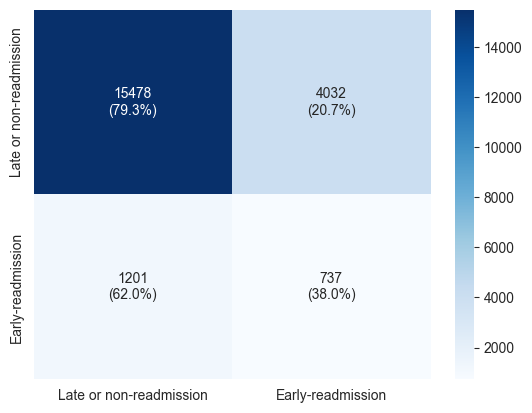

In [72]:
# Visualize confusion matrix with both absolute and percentage values
cm_smotetomek = confusion_matrix(y_test, y_test_pred_smotetomek)
cm_smotetomek_norm = confusion_matrix(y_test, y_test_pred_smotetomek, normalize='true')

annotations_smotetomek = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smotetomek, cm_smotetomek_norm)
])

sns.heatmap(
    cm_smotetomek,
    annot=annotations_smotetomek,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **6. Results Combined**
Visualizing all results obtained by different sampling methods, on the best respective models.

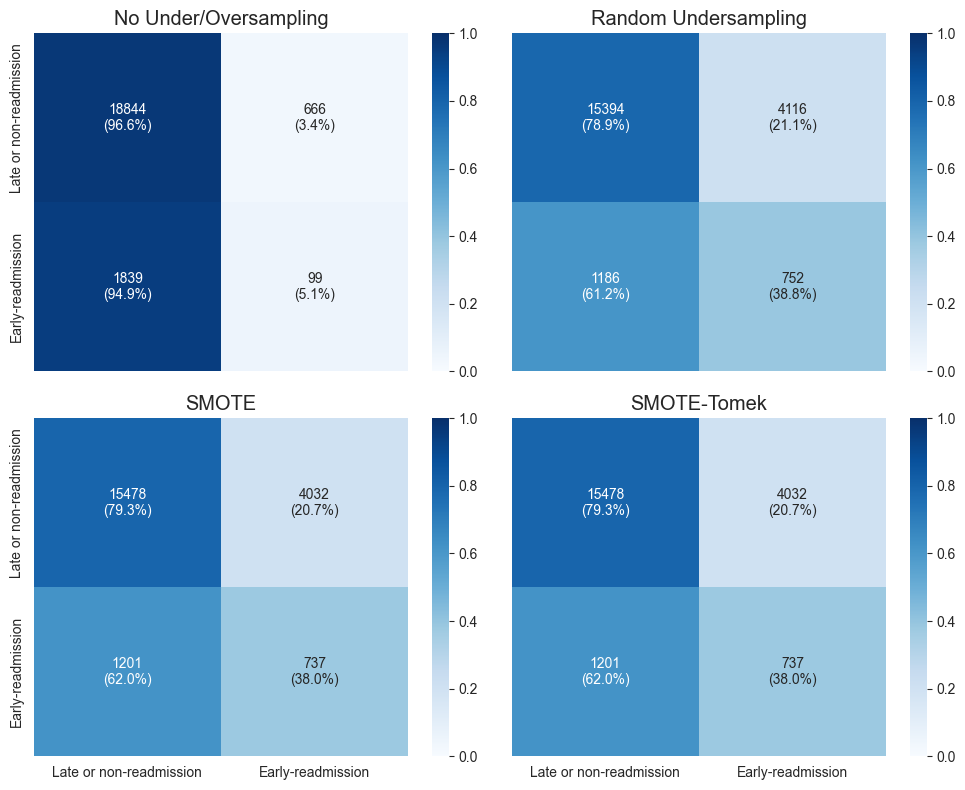

In [73]:
# Combine all confusion matrices into a single plot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
cm_list = [cm_none_norm, cm_rus_norm, cm_smote_norm, cm_smotetomek_norm]
annotations = [annotations_none, annotations_rus, annotations_smote, annotations_smotetomek]
labels = ['No Under/Oversampling', 'Random Undersampling', 'SMOTE', 'SMOTE-Tomek']

# Define tick labels
xticklabels = ['Late or non-readmission', 'Early-readmission']
yticklabels = ['Late or non-readmission', 'Early-readmission']

for i, cm in enumerate(cm_list):
    ax=axs[i//2, i%2]
    sns.heatmap(
        cm,
        annot=annotations[i],
        cmap='Blues',
        fmt='',
        vmin=0, vmax=1,
        ax=axs[i//2, i%2],
        xticklabels=['Late or non-readmission', 'Early-readmission'],
        yticklabels=['Late or non-readmission', 'Early-readmission']
    )
    ax.set_title(labels[i])
    
    # Hide x-tick labels for the top row
    if i < 2:
        ax.set_xticklabels([])
    # Hide y-tick labels for the right column
    if i % 2 == 1:
        ax.set_yticklabels([])

plt.tight_layout()
plt.show()

Visualizing the scores for each method.

In [74]:
# Combine all metrics into a single DataFrame
data = {
    'Recall': [recall_none, recall_rus, recall_smote, recall_smotetomek],
    'Precision': [precision_none, precision_rus, precision_smote, precision_smotetomek],
    'F1-score': [f1_none, f1_rus, f1_smote, f1_smotetomek],
    'ROC-AUC': [roc_auc_none, roc_auc_rus, roc_auc_smote, roc_auc_smotetomek],
    'Accuracy': [accuracy_none, accuracy_rus, accuracy_smote, accuracy_smotetomek]
}

metrics_df = pd.DataFrame(data, index=labels)
metrics_df

,Recall,Precision,F1-score,ROC-AUC,Accuracy
No Under/Oversampling,0.508474,0.520249,0.505464,0.508474,0.883206
Random Undersampling,0.588530,0.541473,0.537035,0.588530,0.752797
SMOTE,0.586813,0.541267,0.537584,0.586813,0.756015
SMOTE-Tomek,0.586813,0.541267,0.537584,0.586813,0.756015


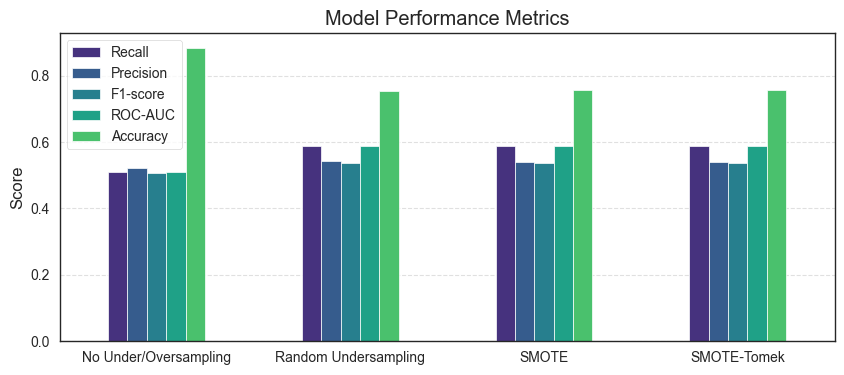

In [75]:
# Visualize all metrics in a bar plot, by coloring each method differently, using SeaBorn barplot and adding grids
sns.set_palette('viridis')
metrics_df.plot(kind='bar', figsize=(10, 4))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()